In [1]:
# enabling 3rd party widgets
# from google.colab import output
# output.enable_custom_widget_manager()
# output.disable_custom_widget_manager()

# interactive 3D plot
# !pip install ipympl
# %matplotlib widget

In [2]:
import os
import sys
import math
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

import time as time
import platform as platform

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import L2
import h5py

tf.keras.backend.set_floatx('float32')

In [3]:
colab_flag = False
FTYPE = np.float32
ITYPE = np.int32

array = np.array
float32 = np.float32
int32 = np.int32
float64 = np.float64
int64 = np.int64

strategy = None
# strategy = tf.distribute.MirroredStrategy()

In [4]:
current_sys = platform.system()

if current_sys == 'Windows':
    dir_sep = '\\'
else:
    dir_sep = '/'

In [5]:
if colab_flag == True:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/Github/MLROM/KS/')

In [6]:
print(os.getcwd())

/home/rkaushik/Documents/Thesis/MLROM/KS


In [7]:
from tools.misc_tools import create_data_for_RNN, mytimecallback, SaveLosses, plot_losses, plot_reconstructed_data_KS, plot_latent_states_KS , readAndReturnLossHistories, sigmoidWarmupAndDecayLRSchedule
from tools.ae_v5 import Autoencoder
from tools.ESN_v4 import ESN

In [8]:
behaviour = 'initialiseAndTrainFromScratch'
# behaviour = 'loadCheckpointAndContinueTraining'
# behaviour = 'loadFinalNetAndPlot'

In [9]:
# setting seed for PRNGs
if behaviour == 'initialiseAndTrainFromScratch':
    prng_seed = 42
    np.random.seed(prng_seed)
    tf.random.set_seed(prng_seed)

In [10]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)

if colab_flag == False:
    if strategy is None:
        if gpus:
            gpu_to_use = 0
            tf.config.set_visible_devices(gpus[gpu_to_use], 'GPU')
    logical_devices = tf.config.list_logical_devices('GPU')
    print(logical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]


2022-12-24 20:09:06.072624: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-24 20:09:06.073245: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-24 20:09:06.137980: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-24 20:09:06.138410: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-24 20:09:06.138780: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

In [11]:
# print(tf.test.gpu_device_name())
print(tf.config.list_physical_devices())
print(tf.config.list_logical_devices())
print(tf.__version__)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
[LogicalDevice(name='/device:CPU:0', device_type='CPU'), LogicalDevice(name='/device:GPU:0', device_type='GPU')]
2.8.1


# KS System

In [12]:
# setting up params (and saving, if applicable)
# from numpy import *

if behaviour == 'initialiseAndTrainFromScratch':
    # making RNN save directory
    dir_name_rnn = os.getcwd() + dir_sep + 'saved_ESN'
    if not os.path.isdir(dir_name_rnn):
        os.makedirs(dir_name_rnn)

    counter = 0
    while True:
        dir_check = 'ESN_' + str(counter).zfill(3)
        if os.path.isdir(dir_name_rnn + dir_sep + dir_check):
            counter += 1
        else:
            break

    dir_name_rnn = dir_name_rnn + dir_sep + dir_check
    os.makedirs(dir_name_rnn)
    os.makedirs(dir_name_rnn+dir_sep+'plots')
    
    # whether to use AE data or just work on raw data
    use_ae_data = True # if false, specifying ae_idx will only show which dataset to use
    
    # autoencoder directory
    ae_idx = '046'
    dir_name_ae = os.getcwd()+'{ds}saved_ae{ds}ae_'.format(ds=dir_sep)+ae_idx
else:
    # RNN directory
    dir_name_rnn = os.getcwd()+'/saved_ESN/ESN_026'

    # reading AE directory
    with open(dir_name_rnn + '/sim_data_AE_params.txt') as f:
        lines = f.readlines()

    params_dict = eval(''.join(lines))

    use_ae_data = params_dict['use_ae_data']
    
    dir_name_ae = params_dict['dir_name_ae']
    ae_idx = dir_name_ae[-3:]
    dir_name_ae = os.getcwd()+'/saved_ae/ae_'+ae_idx

    # reading RNN paramaters
    with open(dir_name_rnn + '/RNN_specific_data.txt') as f:
        lines = f.readlines()

    params_rnn_dict = eval(''.join(lines))

    dt_rnn = params_rnn_dict['dt_rnn']
    T_sample_input = params_rnn_dict['T_sample_input']
    T_sample_output = params_rnn_dict['T_sample_output']
    T_offset = params_rnn_dict['T_offset']
    return_params_arr = params_rnn_dict['return_params_arr']
    params = params_rnn_dict['params']
    try:
        normalize_dataset = params_rnn_dict['normalize_dataset']
    except:
        print("'normalize_dataset' not present in RNN_specific_data, set to False.")
        normalize_dataset = False
    try:
        stddev_multiplier = params_rnn_dict['stddev_multiplier']
    except:
        print("'stddev_multiplier' not present in RNN_specific_data, set to None.")
        stddev_multiplier = None
    try:
        skip_intermediate = params_rnn_dict['skip_intermediate']
    except:
        print("'skip_intermediate' not present in RNN_specific_data, set to 1.")
        skip_intermediate = 1
    try:
        normalization_type = params_rnn_dict['normalization_type']
    except:
        print("'normalization_type' not present in RNN_specific_data, set to 'stddev'.")
        normalization_type = 'stddev'
    

    normalization_arr = None
    try:
        with open(dir_name_rnn + '/final_net/rnn_normalization.txt') as f:
            lines = f.readlines()
        rnn_norm_arr_dict = eval(lines)
        normalization_arr = rnn_norm_arr_dict['normalization_arr']
    except:
        pass
    if os.path.exists(dir_name_rnn+dir_sep+'normalization_data.npz'):
        with np.load(dir_name_rnn+dir_sep+'normalization_data.npz', allow_pickle=True) as fl:
            normalization_arr = fl['normalization_arr'][0]

# reading simulation parameters
with open(dir_name_ae + dir_sep + 'ae_data.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
data_dir_idx = params_dict['data_dir_idx']
normalizeforae_flag = params_dict['normalizeforae_flag']
normalization_constant_arr_aedata = params_dict['normalization_constant_arr_aedata']
try:
    ae_data_with_params = params_dict['ae_data_with_params']
except:
    print("'ae_data_with_params' not present in ae_data, set to 'True'.")
    ae_data_with_params = True

if os.path.exists(dir_name_ae+dir_sep+'normalization_data.npz'):
    with np.load(dir_name_ae+dir_sep+'normalization_data.npz', allow_pickle=True) as fl:
        normalization_constant_arr_aedata = fl['normalization_constant_arr_aedata'][0]

print('dir_name_rnn:', dir_name_rnn)
print('use_ae_data : ' + str(use_ae_data) + ', dir_name_ae:', dir_name_ae)
print('data_dir_idx:', data_dir_idx)

# loading data
dir_name_data = os.getcwd() + dir_sep + 'saved_data' + dir_sep + 'data_' + data_dir_idx
    
with open(dir_name_data + dir_sep + 'sim_data_params.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
params_mat = params_dict['params_mat']
# init_state = params_dict['init_state']
t0 = params_dict['t0']
T = params_dict['T']
delta_t = params_dict['delta_t']
numpoints_xgrid = params_dict['numpoints_xgrid']
length = params_dict['length']
return_params_arr = params_dict['return_params_arr']
normalize_flag_ogdata = params_dict['normalize_flag']
print('normalize_flag_ogdata:', normalize_flag_ogdata)
alldata_withparams_flag = params_dict['alldata_withparams_flag']

xgrid = length*np.linspace(0, 1, numpoints_xgrid)

with np.load(dir_name_data+dir_sep+'data.npz', allow_pickle=True) as fl:
    all_data = fl['all_data']
    boundary_idx_arr = fl['boundary_idx_arr']
    normalization_constant_arr_ogdata = fl['normalization_constant_arr'][0]
    initial_t0 = fl['initial_t0']
    init_state_mat = fl['init_state_mat']

    lyapunov_spectrum_mat = fl['lyapunov_spectrum_mat']

dir_name_rnn: /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030
use_ae_data : True, dir_name_ae: /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_046
data_dir_idx: 005
normalize_flag_ogdata: False


In [13]:
lyapunov_time_arr = np.empty(shape=lyapunov_spectrum_mat.shape[0], dtype=FTYPE)
for i in range(lyapunov_spectrum_mat.shape[0]):
    lyapunov_time_arr[i] = 1/lyapunov_spectrum_mat[i, 0]
    print('Case : {}, lyapunov exponent : {}, lyapunov time : {}s'.format(i+1, lyapunov_spectrum_mat[i, 0], lyapunov_time_arr[i]))

Case : 1, lyapunov exponent : 0.06465670311438651, lyapunov time : 15.466300964355469s


In [14]:
def plot(
        boundary_idx_arr,
        delta_t,
        all_data,
        xgrid,
        xticks_snapto=20,
        num_yticks=11,
    ):

    n = len(boundary_idx_arr)
    # '''
    num_cols = 1
    num_rows = 1
    factor = 1
    # fig = plt.figure(figsize=(7.5*num_cols, 7.5*num_rows))

    num_modes = xgrid.shape[0]

    prev_idx = 0
    for i in range(len(boundary_idx_arr)):
        next_idx = boundary_idx_arr[i]
        fig, ax = plt.subplots(figsize=(factor*7.5*num_cols, factor*5.0*num_rows))
        N = next_idx - prev_idx
        input_time = np.arange(0, N)*delta_t

        im = ax.imshow(all_data[prev_idx:next_idx, 0:num_modes].transpose(), aspect='auto', origin='lower')
        num_xticks = 1 + int((N*delta_t + 0.5*xticks_snapto) // xticks_snapto)
        # xticks = np.linspace(0, N, num_xticks, dtype=np.int32)
        xticks = np.arange(0, N, int((xticks_snapto+0.5*delta_t)//delta_t))
        ax.set_xticks(ticks=xticks)
        ax.set_xticklabels(np.round(xticks*delta_t, 1))
        ax.tick_params(axis='x', rotation=270+45)

        yticks = np.linspace(0, 1, num_yticks)*(len(xgrid)-1)
        yticklabels = np.round(np.linspace(0, 1, yticks.shape[0])*xgrid[-1], 2)
        ax.set_yticks(ticks=yticks)
        ax.set_yticklabels(yticklabels)

        ax.set_xlabel('Time')
        ax.set_ylabel(r'$x$')
        # ax.title.set_text(r'Latent States')

        plt.colorbar(im)
        plt.show()
        print('')

        prev_idx = next_idx

    # '''

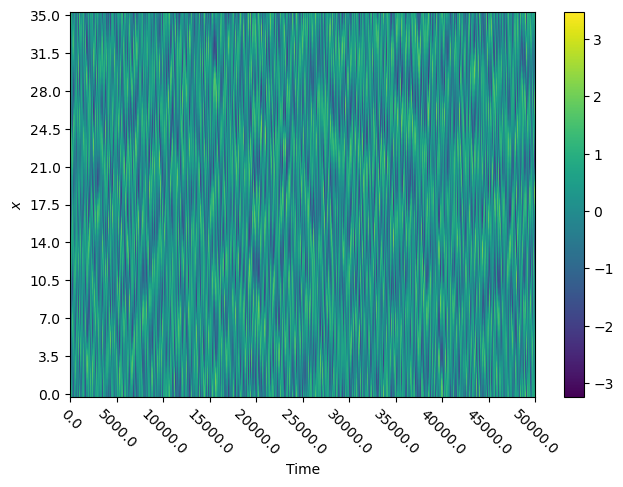

In [15]:
plot(
    boundary_idx_arr,
    delta_t,
    all_data,
    xgrid,
    xticks_snapto=int(40*np.round((T//10)/40))
)

In [16]:
# delaing with normalizing the data before feeding into autoencoder
if use_ae_data == True:
    if normalizeforae_flag == True:
        for i in range(numpoints_xgrid):
            all_data[:, i] -= normalization_constant_arr_aedata[0, i]
            all_data[:, i] /= normalization_constant_arr_aedata[1, i]

    if ae_data_with_params == False:
        all_data = all_data[:, 0:numpoints_xgrid]
else:
    # using raw data, neglecting the params attached (if any)
    all_data = all_data[:, 0:numpoints_xgrid]

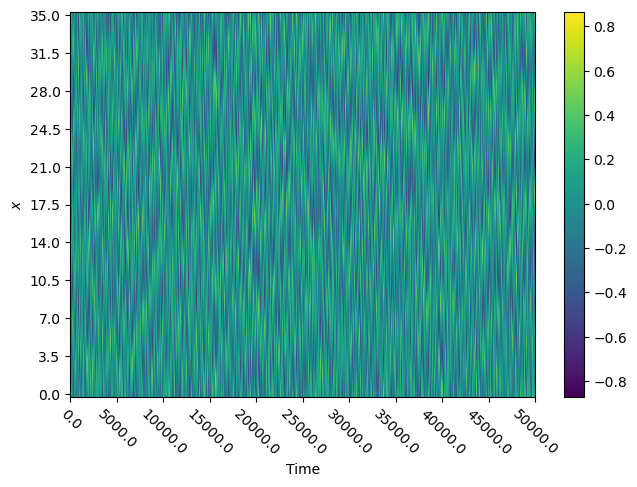

In [17]:
plot(
    boundary_idx_arr,
    delta_t,
    all_data,
    xgrid,
    xticks_snapto=int(40*np.round((T//10)/40))
)

# Autoencoder

In [18]:
if use_ae_data == True:
    load_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_class_dict.txt'
    wt_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_ae_weights.h5'

In [19]:
if use_ae_data == True:
    ae_net = Autoencoder(all_data.shape[1], load_file=load_file)
    ae_net.load_weights_from_file(wt_file)

In [20]:
# create data
if use_ae_data == True:
    latent_states_all = ae_net.encoder_net.predict(all_data)
    del(all_data)
else:
    latent_states_all = all_data
num_latent_states = latent_states_all.shape[1]
time_stddev_AEproducedlatentstates = np.std(latent_states_all, axis=0)

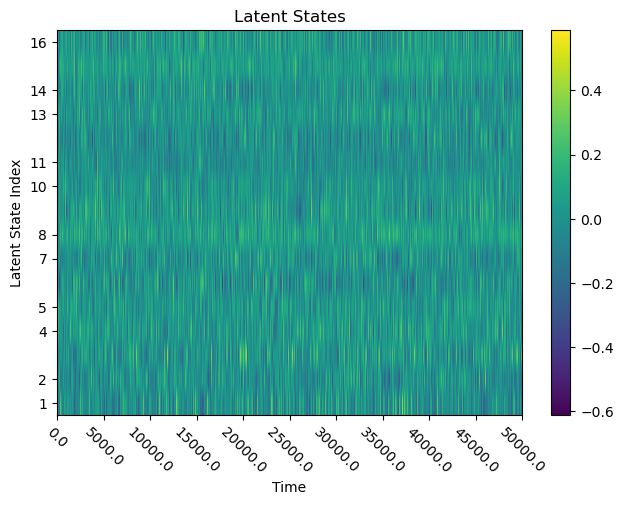

In [21]:
plot_latent_states_KS(
    boundary_idx_arr,
    latent_states_all,
    delta_t,
    dir_name_ae,
    xticks_snapto=int(40*np.round((T//10)/40)),
    num_yticks=11,
    save_figs=False)

In [22]:
# for i in range(ae_net.layers):
#     tf.keras.utils.plot_model(
#         ae_net.layers[i],
#         to_file=dir_name_ae+'/plots/netlayer_{}.png'.format(i),
#         show_shapes=True,
#         dpi=300
# )

# ESN

In [23]:
if behaviour == 'initialiseAndTrainFromScratch':
    # RNN data parameters
    dt_rnn = 0.2
    num_input_tsteps = 375
    T_sample_input = num_input_tsteps*dt_rnn
    T_sample_output = T_sample_input
    T_offset = dt_rnn
    normalize_dataset = True # whether the data for the RNN should be normalized by the dataset's mean and std
    normalization_arr = None
    stddev_multiplier = 3
    skip_intermediate = 'full sample'
    noise_type = 'normal' # can be 'uniform' or 'normal'
    normalization_type = 'stddev' # can be 'minmax' or 'stddev', if it is
                                  # 'minmax' then stddev_multiplier has no effect
    ESN_layers_units = [5000]
    stateful = True
    omega_in = [1.0]
    degree_of_connectivity = [80]
    rho_res = [0.6]
    usebias_Win = [False]
    alpha = [1.0]
    ESN_cell_activations = ['tanh']
    usebias_Wout = True
    
    activation_post_Wout = 'tanh'
    use_weights_post_dense = True
    
    # computing sparsity
    sparsity = [1-degree_of_connectivity[i]/(ESN_layers_units[i]-1) for i in range(len(ESN_layers_units))]
        
    if return_params_arr != False:
        params = params_arr
    else:
        params = None
        

    # saving simulation data
    sim_data = {
        'params_mat':params_mat,
        'init_state_mat':init_state_mat,
        't0':t0,
        'T':T,
        'delta_t':delta_t,
        'return_params_arr':return_params_arr, # pointless, saved_data parameter
        'dir_name_ae':dir_name_ae,
        'normalize_dataset':normalize_dataset, # pointless, RNN parameter
        'stddev_multiplier':stddev_multiplier, # pointless, RNN parameter
        'use_ae_data':use_ae_data,
    }


    with open(dir_name_rnn+dir_sep+'sim_data_AE_params.txt', 'w') as f:
        f.write(str(sim_data))
        
    # saving RNN specific data
    RNN_specific_data = {
        'dt_rnn':dt_rnn,
        'T_sample_input':T_sample_input,
        'T_sample_output':T_sample_output,
        'T_offset':T_offset,
        'boundary_idx_arr':boundary_idx_arr,
        'delta_t':delta_t,
        'params':params,
        'return_params_arr':return_params_arr,
        'normalize_dataset':normalize_dataset,
        'num_input_tsteps':num_input_tsteps,
        'stddev_multiplier':stddev_multiplier,
        'skip_intermediate':skip_intermediate,
        'module':ESN.__module__,
        'noise_type':noise_type,
        'normalization_type':normalization_type,
    }

    with open(dir_name_rnn+dir_sep+'RNN_specific_data.txt', 'w') as f:
        f.write(str(RNN_specific_data))

In [24]:
rnn_res_dict = create_data_for_RNN(
    latent_states_all,
    dt_rnn,
    T_sample_input,
    T_sample_output,
    T_offset,
    None,
    boundary_idx_arr,
    delta_t,
    params=params,
    return_numsamples=True,
    normalize_dataset=normalize_dataset,
    stddev_multiplier=stddev_multiplier,
    skip_intermediate=skip_intermediate,
    return_OrgDataIdxArr=False,
    normalization_arr_external=normalization_arr,
    normalization_type=normalization_type,
    FTYPE=FTYPE,
    ITYPE=ITYPE)
    
data_rnn_input = rnn_res_dict['data_rnn_input']
data_rnn_output = rnn_res_dict['data_rnn_output']
org_data_idx_arr_input = rnn_res_dict['org_data_idx_arr_input']
org_data_idx_arr_output = rnn_res_dict['org_data_idx_arr_output']
num_samples = rnn_res_dict['num_samples']
normalization_arr = rnn_res_dict['normalization_arr']
rnn_data_boundary_idx_arr = rnn_res_dict['rnn_data_boundary_idx_arr']

In [25]:
temp = np.divide(latent_states_all-normalization_arr[0], normalization_arr[1])
time_stddev = np.std(temp, axis=0)
timeMeanofSpaceRMS = np.mean(np.mean(temp**2, axis=1)**0.5)
del(org_data_idx_arr_input)
del(org_data_idx_arr_output)
del(latent_states_all)
del(temp)

In [26]:
# setting up training params
if behaviour == 'initialiseAndTrainFromScratch':
    learning_rate_list = [1e-3, 1e-4, 1e-5]
    epochs = 1000
    patience = 25 # parameter for early stopping
    min_delta = 1e-6  # parameter for early stopping
    lambda_reg = 1e-6  # weight for regularizer
    train_split = 0.8
    val_split = 0.1
    test_split = 1 - train_split - val_split
    batch_size = 32
    fRMS = 0.5/100
    # zoneout_rate = 0.1
    # rnncell_dropout_rate = 0.01
    # denselayer_dropout_rate = 0.01
    

    stddev = fRMS*timeMeanofSpaceRMS
    
    # saving training params
    training_specific_params = {
        'learning_rate_list':learning_rate_list,
        'epochs':epochs,
        'patience':patience,
        'min_delta':min_delta,
        'prng_seed':prng_seed,
        'train_split':train_split,
        'val_split':val_split,
        'batch_size':batch_size,
        'fRMS':fRMS,
        'timeMeanofSpaceRMS':timeMeanofSpaceRMS,
        'stddev':stddev,
        # 'zoneout_rate':zoneout_rate,
        # 'rnncell_dropout_rate':rnncell_dropout_rate,
        # 'denselayer_dropout_rate':denselayer_dropout_rate,
    }

    with open(dir_name_rnn+dir_sep+'training_specific_params.txt', 'w') as f:
        f.write(str(training_specific_params))
    
    np.savez(
        dir_name_rnn+dir_sep+'normalization_data',
        normalization_arr=[normalization_arr],
    )
    
else:
    # dir_name_rnn_og = dir_name_rnn
    # dir_name_rnn_temp = '/home/rkaushik/Documents/Thesis/MLROM/CDV/saved_rnn/rnn_'+dir_name_rnn_og[-3:]
    # dir_name_rnn = dir_name_rnn_temp

    with open(dir_name_rnn + dir_sep + 'training_specific_params.txt') as f:
        lines = f.readlines()


    tparams_dict = eval(''.join(lines))

    learning_rate_list = tparams_dict['learning_rate_list']
    epochs = tparams_dict['epochs']
    patience = tparams_dict['patience']
    min_delta = tparams_dict['min_delta']
    prng_seed = tparams_dict['prng_seed']
    train_split = tparams_dict['train_split']
    val_split = tparams_dict['val_split']
    batch_size = tparams_dict['batch_size']

    test_split = 1 - train_split - val_split

    # setting seed for PRNGs
    np.random.seed(prng_seed)
    tf.random.set_seed(prng_seed)

In [27]:
# idx = np.arange(data_rnn_input.shape[0])
# np.random.shuffle(idx)
# boundary = int(np.round(train_split*data_rnn_input.shape[0]))

# training_data_rnn_input = data_rnn_input[idx[0:boundary]]
# training_data_rnn_output = data_rnn_output[idx[0:boundary]]

# testing_data_rnn_input = data_rnn_input[idx[boundary:]]
# testing_data_rnn_output = data_rnn_output[idx[boundary:]]

In [28]:
cum_samples = rnn_data_boundary_idx_arr[-1]
# idx = np.arange(cum_samples)
# np.random.shuffle(idx)
num_train_arr = np.zeros(shape=rnn_data_boundary_idx_arr.shape[0], dtype='int32')
num_val_arr = np.zeros(shape=rnn_data_boundary_idx_arr.shape[0], dtype='int32')
num_test_arr = np.zeros(shape=rnn_data_boundary_idx_arr.shape[0], dtype='int32')
num_samples_arr = np.zeros(shape=rnn_data_boundary_idx_arr.shape[0], dtype='int32')
begin_idx = 0
for i in range(len(rnn_data_boundary_idx_arr)):
    num_samples = rnn_data_boundary_idx_arr[i] - begin_idx
    num_train_arr[i] = batch_size * (int( (1-test_split-val_split)*num_samples )//batch_size)
    num_val_arr[i] = batch_size * (int(val_split*num_samples)//batch_size)
    num_test_arr[i] = batch_size * int((num_samples - num_train_arr[i] - num_val_arr[i])//batch_size)
    num_samples_arr[i] = num_train_arr[i] + num_val_arr[i] + num_test_arr[i]
    begin_idx = rnn_data_boundary_idx_arr[i]

# defining shapes
training_input_shape = [np.sum(num_train_arr)]
training_input_shape.extend(data_rnn_input.shape[1:])

training_output_shape = [np.sum(num_train_arr)]
training_output_shape.extend(data_rnn_output.shape[1:])

val_input_shape = [np.sum(num_val_arr)]
val_input_shape.extend(data_rnn_input.shape[1:])

val_output_shape = [np.sum(num_val_arr)]
val_output_shape.extend(data_rnn_output.shape[1:])

testing_input_shape = [np.sum(num_test_arr)]
testing_input_shape.extend(data_rnn_input.shape[1:])

testing_output_shape = [np.sum(num_test_arr)]
testing_output_shape.extend(data_rnn_output.shape[1:])

# defining required arrays
training_data_rnn_input = np.empty(shape=training_input_shape, dtype=FTYPE)
training_data_rnn_output = np.empty(shape=training_output_shape, dtype=FTYPE)

val_data_rnn_input = np.empty(shape=val_input_shape, dtype=FTYPE)
val_data_rnn_output = np.empty(shape=val_output_shape, dtype=FTYPE)

testing_data_rnn_input = np.empty(shape=testing_input_shape, dtype=FTYPE)
testing_data_rnn_output = np.empty(shape=testing_output_shape, dtype=FTYPE)

begin_idx = 0
training_data_rolling_count = 0
val_data_rolling_count = 0
testing_data_rolling_count = 0
for i in range(len(rnn_data_boundary_idx_arr)):
    idx = np.arange(begin_idx, rnn_data_boundary_idx_arr[i])
    # np.random.shuffle(idx)
    # num_samples = idx.shape[0]
    # num_train = int( (1-test_split-val_split)*num_samples )
    # num_val = int(val_split*num_samples)
    num_samples = num_samples_arr[i]
    num_train = num_train_arr[i]
    num_val = num_val_arr[i]
    num_test = num_test_arr[i]
    
    nbatches_train = num_train // batch_size
    nbatches_val = num_val // batch_size
    nbatches_test = num_test // batch_size

    for j in range(batch_size):
        training_data_rnn_input[training_data_rolling_count+j:training_data_rolling_count+num_train:batch_size] = data_rnn_input[idx[0:num_train]][j*nbatches_train:(j+1)*nbatches_train]
        training_data_rnn_output[training_data_rolling_count+j:training_data_rolling_count+num_train:batch_size] = data_rnn_output[idx[0:num_train]][j*nbatches_train:(j+1)*nbatches_train]
        
        val_data_rnn_input[val_data_rolling_count+j:val_data_rolling_count+num_val:batch_size] = data_rnn_input[idx[num_train:num_train+num_val]][j*nbatches_val:(j+1)*nbatches_val]
        val_data_rnn_output[val_data_rolling_count+j:val_data_rolling_count+num_val:batch_size] = data_rnn_output[idx[num_train:num_train+num_val]][j*nbatches_val:(j+1)*nbatches_val]

        testing_data_rnn_input[testing_data_rolling_count+j:testing_data_rolling_count+num_test:batch_size] = data_rnn_input[idx[num_train+num_val:num_samples]][j*nbatches_test:(j+1)*nbatches_test]
        testing_data_rnn_output[testing_data_rolling_count+j:testing_data_rolling_count+num_test:batch_size] = data_rnn_output[idx[num_train+num_val:num_samples]][j*nbatches_test:(j+1)*nbatches_test]


    # training_data_rnn_input[training_data_rolling_count:training_data_rolling_count+num_train] = data_rnn_input[idx[0:num_train]]
    # training_data_rnn_output[training_data_rolling_count:training_data_rolling_count+num_train] = data_rnn_output[idx[0:num_train]]
    training_data_rolling_count += num_train

    # val_data_rnn_input[val_data_rolling_count:val_data_rolling_count+num_val] = data_rnn_input[idx[num_train:num_train+num_val]]
    # val_data_rnn_output[val_data_rolling_count:val_data_rolling_count+num_val] = data_rnn_output[idx[num_train:num_train+num_val]]
    val_data_rolling_count += num_val

    # num_test = num_samples-num_train-num_val+1
    # testing_data_rnn_input[testing_data_rolling_count:testing_data_rolling_count+num_test] = data_rnn_input[idx[num_train+num_val:]]
    # testing_data_rnn_output[testing_data_rolling_count:testing_data_rolling_count+num_test] = data_rnn_output[idx[num_train+num_val:]]
    testing_data_rolling_count += num_test

    begin_idx = rnn_data_boundary_idx_arr[i]

# cleaning up
del(data_rnn_input)
del(data_rnn_output)

# further shuffling
if stateful == False:
    idx = np.arange(0, training_data_rnn_input.shape[0])
    np.random.shuffle(idx)
    training_data_rnn_input = training_data_rnn_input[idx]
    training_data_rnn_output = training_data_rnn_output[idx]

    idx = np.arange(0, val_data_rnn_input.shape[0])
    np.random.shuffle(idx)
    val_data_rnn_input = val_data_rnn_input[idx]
    val_data_rnn_output = val_data_rnn_output[idx]

    idx = np.arange(0, testing_data_rnn_input.shape[0])
    np.random.shuffle(idx)
    testing_data_rnn_input = testing_data_rnn_input[idx]
    testing_data_rnn_output = testing_data_rnn_output[idx]

    del(idx)

In [29]:
print('training_data_rnn_input.shape : ', training_data_rnn_input.shape)
print(' testing_data_rnn_input.shape : ', testing_data_rnn_input.shape)
print('     val_data_rnn_input.shape : ', val_data_rnn_input.shape)

training_data_rnn_input.shape :  (512, 375, 16)
 testing_data_rnn_input.shape :  (64, 375, 16)
     val_data_rnn_input.shape :  (64, 375, 16)


In [30]:
# Initialize network
if behaviour == 'initialiseAndTrainFromScratch':
    # timeMeanofSpaceRMS = np.mean(np.mean(latent_states_all**2, axis=1)**0.5)
    print('timeMeanofSpaceRMS :', timeMeanofSpaceRMS)
    print('stddev :', stddev)
    if return_params_arr != False:
        data_dim = num_latent_states + 3
    else:
        data_dim = num_latent_states


    rnn_net = ESN(
        data_dim=data_dim,
        dt_rnn=dt_rnn,
        lambda_reg=lambda_reg,
        ESN_layers_units=ESN_layers_units,
        stddev=stddev,
        noise_type=noise_type,
        stateful=stateful,
        omega_in=omega_in,
        sparsity=sparsity,
        rho_res=rho_res,
        usebias_Win=usebias_Win,
        alpha=alpha,
        ESN_cell_activations=ESN_cell_activations,
        prng_seed=prng_seed,
        usebias_Wout=usebias_Wout,
        use_weights_post_dense=use_weights_post_dense,
        activation_post_Wout=activation_post_Wout,
        batch_size=batch_size,
    )
    save_path = dir_name_rnn+dir_sep+'final_net'
    if not os.path.isdir(save_path):
        os.makedirs(save_path)
    rnn_net.build(input_shape=(batch_size,) + training_data_rnn_input.shape[1:])
    rnn_net.save_class_dict(save_path+dir_sep+'final_net_class_dict.txt')
else:
    load_file = dir_name_rnn + dir_sep + 'final_net' + dir_sep + 'final_net_class_dict.txt'
    
    rnn_net = ESN(
        load_file=load_file,
    )
    
    if behaviour == 'loadCheckpointAndContinueTraining':
        wt_file = tf.train.latest_checkpoint(dir_name_rnn+dir_sep+'checkpoints')
    elif behaviour == 'loadFinalNetAndPlot':
        wt_file = dir_name_rnn+dir_sep+'final_net'+dir_sep+'final_net_ESN_weights.hdf5'
        # wt_file = dir_name_rnn+dir_sep+'final_net'+dir_sep+'f2'#+dir_sep+'saved_model.pb'
        rnn_net.load_weights_from_file(wt_file)
    
    # this forces the model to initialize its kernel weights/biases
    # temp = rnn_net.predict(tf.ones(shape=[batch_size, int(T_sample_input//dt_rnn), rnn_net.data_dim]))
    # this loads just the kernel wieghts and biases of the model
#     rnn_net.load_weights_from_file(wt_file)

    # rnn_net = tf.keras.models.load_model(wt_file)

timeMeanofSpaceRMS : 0.33066237
stddev : 0.001653311848640442


In [31]:
if behaviour == 'initialiseAndTrainFromScratch':
    val_loss_hist = []
    train_loss_hist = []
    lr_change=[0, 0]
    savelosses_cb_vallossarr = np.ones(shape=epochs*len(learning_rate_list))*np.NaN
    savelosses_cb_trainlossarr = np.ones(shape=epochs*len(learning_rate_list))*np.NaN
    starting_lr_idx = 0
    num_epochs_left = epochs
    earlystopping_wait = 0
elif behaviour == 'loadCheckpointAndContinueTraining':
    val_loss_hist, train_loss_hist, lr_change, starting_lr_idx, num_epochs_left, val_loss_arr_fromckpt, train_loss_arr_fromckpt, earlystopping_wait = readAndReturnLossHistories(
        dir_name_ae=dir_name_rnn,
        dir_sep=dir_sep,
        epochs=epochs,
        learning_rate_list=learning_rate_list,
        return_earlystopping_wait=True)
    savelosses_cb_vallossarr = val_loss_arr_fromckpt
    savelosses_cb_trainlossarr = train_loss_arr_fromckpt
elif behaviour == 'loadFinalNetAndPlot':
    with open(dir_name_rnn+'{ds}final_net{ds}losses.txt'.format(ds=dir_sep), 'r') as f:
        lines = f.readlines()
    
    losses_dict = eval(''.join(lines))

    val_loss_hist = losses_dict['val_loss_hist']
    train_loss_hist = losses_dict['train_loss_hist']
    lr_change = losses_dict['lr_change']
    test_loss = losses_dict['test_loss']

In [32]:
training_data_rnn_input.dtype

dtype('float32')

In [33]:
lambda_reg = float(lambda_reg)

In [34]:
class NMSE(tf.keras.metrics.MeanSquaredError):
    def __init__(self, divisor_arr, name='NMSE', **kwargs):
        super(NMSE, self).__init__(name, **kwargs)
        self.divisor_arr = divisor_arr

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = y_true / self.divisor_arr
        y_pred = y_pred / self.divisor_arr
        return super(NMSE, self).update_state(y_true, y_pred, sample_weight)

In [35]:
# compiling the network
rnn_net.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate_list[0]),
    loss=losses.MeanSquaredError(),
    metrics=['mse', NMSE(divisor_arr=time_stddev)],
    run_eagerly=False
)

if behaviour == 'loadCheckpointAndContinueTraining':
    # this loads the weights/attributes of the optimizer as well
    if strategy is not None:
        with strategy.scope():
            rnn_net.load_weights(wt_file)
    else:
        rnn_net.load_weights(wt_file)

if behaviour == 'initialiseAndTrainFromScratch' or behaviour == 'loadCheckpointAndContinueTraining':
    # implementing early stopping
    baseline = None
    if behaviour == 'loadCheckpointAndContinueTraining':
        baseline = np.min(val_loss_hist)
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor='val_NMSE',
        patience=patience,
        restore_best_weights=True,
        verbose=True,
        min_delta=min_delta,
        baseline=baseline
    )
    #** the two lines below are useless because wait is set to 0 in on_train_begin
    # early_stopping_cb.wait = earlystopping_wait
    # print('early_stopping_cb.wait : {}\n'.format(early_stopping_cb.wait))

    # time callback for each epoch
    timekeeper_cb = mytimecallback()

    # model checkpoint callback
    dir_name_ckpt = dir_name_rnn+dir_sep+'checkpoints'
    if not os.path.isdir(dir_name_ckpt):
        os.makedirs(dir_name_ckpt)
    checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
        filepath=dir_name_ckpt+dir_sep+'checkpoint',#+'/checkpoint--loss={loss:.4f}--vall_loss={val_loss:.4f}',
        monitor='val_NMSE',
        save_best_only=True,
        save_weights_only=True,
        verbose=2,
        initial_value_threshold=baseline,
        period=1  # saves every `period` epochs
    )

    # save losses callback
    savelosses_cb = SaveLosses(
        filepath=dir_name_ckpt+dir_sep+'LossHistoriesCheckpoint',
        val_loss_arr=savelosses_cb_vallossarr,
        train_loss_arr=savelosses_cb_trainlossarr,
        total_epochs=epochs,
        period=1)

    val_MSE_hist = []
    train_MSE_hist = []
    val_NMSE_hist = []
    train_NMSE_hist = []
    for i in range(starting_lr_idx, len(learning_rate_list)):
        learning_rate = learning_rate_list[i]
        K.set_value(rnn_net.optimizer.lr, learning_rate)

        savelosses_cb.update_lr_idx(i)

        if i == starting_lr_idx:
            EPOCHS = num_epochs_left
            savelosses_cb.update_offset(epochs-num_epochs_left)
        else:
            EPOCHS = epochs
            savelosses_cb.update_offset(0)

        total_s_len = 80
        sep_lr_s = ' LEARNING RATE : {} '.format(learning_rate)
        sep_lr_s = int((total_s_len - len(sep_lr_s))//2)*'-' + sep_lr_s
        sep_lr_s = sep_lr_s + (total_s_len-len(sep_lr_s))*'-'
        print('\n\n' + '-'*len(sep_lr_s))
        print('\n' + sep_lr_s+'\n')
        print('-'*len(sep_lr_s) + '\n\n')
        
        history = rnn_net.fit(training_data_rnn_input, training_data_rnn_output,
            epochs=EPOCHS,
            batch_size=batch_size,
#             validation_split=val_split/train_split,
            validation_data=(val_data_rnn_input, val_data_rnn_output),
            callbacks=[early_stopping_cb, timekeeper_cb, checkpoint_cb, savelosses_cb],
            verbose=1,
            shuffle=not stateful,
        )

        val_loss_hist.extend(history.history['val_loss'])
        train_loss_hist.extend(history.history['loss'])
        
        val_NMSE_hist.extend(history.history['val_NMSE'])
        train_NMSE_hist.extend(history.history['NMSE'])

        val_MSE_hist.extend(history.history['val_mse'])
        train_MSE_hist.extend(history.history['mse'])
        
        if i == starting_lr_idx:
            lr_change[i+1] += len(history.history['val_loss'])
        else:
            lr_change.append(lr_change[i]+len(history.history['val_loss']))



--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.001 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/1000
16/16 [==============================] - ETA: 0s - loss: 0.0388 - mse: 0.0387 - NMSE: 0.3486 - tot_time: 0h 0m 16.5s

Epoch 1: val_NMSE improved from inf to 0.13613, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 17s 1s/step - loss: 0.0388 - mse: 0.0387 - NMSE: 0.3486 - val_loss: 0.0152 - val_mse: 0.0151 - val_NMSE: 0.1361
Epoch 2/1000
16/16 [==============================] - ETA: 0s - loss: 0.0077 - mse: 0.0076 - NMSE: 0.0686 - tot_time: 0h 0m 32.3s

Epoch 2: val_NMSE improved from 0.13613 to 0.03634, saving model to

Epoch 15/1000
16/16 [==============================] - ETA: 0s - loss: 6.4038e-04 - mse: 5.8436e-04 - NMSE: 0.0053 - tot_time: 0h 4m 6.0s

Epoch 15: val_NMSE improved from 0.00605 to 0.00588, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 18s 1s/step - loss: 6.4038e-04 - mse: 5.8436e-04 - NMSE: 0.0053 - val_loss: 7.0973e-04 - val_mse: 6.5370e-04 - val_NMSE: 0.0059
Epoch 16/1000
16/16 [==============================] - ETA: 0s - loss: 6.2549e-04 - mse: 5.6946e-04 - NMSE: 0.0051 - tot_time: 0h 4m 23.7s

Epoch 16: val_NMSE improved from 0.00588 to 0.00574, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossHistoriesCheckpoint
16/1

16/16 [==============================] - ETA: 0s - loss: 5.0313e-04 - mse: 4.4709e-04 - NMSE: 0.0040 - tot_time: 0h 7m 57.3s

Epoch 29: val_NMSE improved from 0.00451 to 0.00445, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 16s 1s/step - loss: 5.0313e-04 - mse: 4.4709e-04 - NMSE: 0.0040 - val_loss: 5.5083e-04 - val_mse: 4.9480e-04 - val_NMSE: 0.0045
Epoch 30/1000
16/16 [==============================] - ETA: 0s - loss: 4.9457e-04 - mse: 4.3853e-04 - NMSE: 0.0039 - tot_time: 0h 8m 13.7s

Epoch 30: val_NMSE improved from 0.00445 to 0.00440, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossHistoriesCheckpoint
16/16 [==========

16/16 [==============================] - ETA: 0s - loss: 4.0092e-04 - mse: 3.4479e-04 - NMSE: 0.0031 - tot_time: 0h 11m 47.7s

Epoch 43: val_NMSE improved from 0.00360 to 0.00357, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 16s 1s/step - loss: 4.0092e-04 - mse: 3.4479e-04 - NMSE: 0.0031 - val_loss: 4.5274e-04 - val_mse: 3.9660e-04 - val_NMSE: 0.0036
Epoch 44/1000
16/16 [==============================] - ETA: 0s - loss: 3.9716e-04 - mse: 3.4101e-04 - NMSE: 0.0031 - tot_time: 0h 12m 4.1s

Epoch 44: val_NMSE improved from 0.00357 to 0.00353, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossHistoriesCheckpoint
16/16 [=========

16/16 [==============================] - ETA: 0s - loss: 3.3551e-04 - mse: 2.7914e-04 - NMSE: 0.0025 - tot_time: 0h 15m 39.6s

Epoch 57: val_NMSE improved from 0.00287 to 0.00282, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 17s 1s/step - loss: 3.3551e-04 - mse: 2.7914e-04 - NMSE: 0.0025 - val_loss: 3.6949e-04 - val_mse: 3.1310e-04 - val_NMSE: 0.0028
Epoch 58/1000
16/16 [==============================] - ETA: 0s - loss: 3.3196e-04 - mse: 2.7557e-04 - NMSE: 0.0025 - tot_time: 0h 15m 56.6s

Epoch 58: val_NMSE improved from 0.00282 to 0.00273, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossHistoriesCheckpoint
16/16 [========

Epoch 72/1000
16/16 [==============================] - ETA: 0s - loss: 2.9251e-04 - mse: 2.3593e-04 - NMSE: 0.0021 - tot_time: 0h 19m 44.1s

Epoch 72: val_NMSE did not improve from 0.00225
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 16s 980ms/step - loss: 2.9251e-04 - mse: 2.3593e-04 - NMSE: 0.0021 - val_loss: 3.4268e-04 - val_mse: 2.8609e-04 - val_NMSE: 0.0026
Epoch 73/1000
16/16 [==============================] - ETA: 0s - loss: 3.1522e-04 - mse: 2.5864e-04 - NMSE: 0.0023 - tot_time: 0h 19m 59.6s

Epoch 73: val_NMSE did not improve from 0.00225
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 16s 979ms/step - loss: 3.1522e-04 - mse: 2.5864e-04 - NMSE: 0.0023 - val_loss: 3.5297e-04 - val_mse: 2.9638e-04 - val_NMSE: 0.0027
Epoch 74/1000
16/16 [===========

Epoch 88/1000
16/16 [==============================] - ETA: 0s - loss: 2.6104e-04 - mse: 2.0447e-04 - NMSE: 0.0018 - tot_time: 0h 24m 0.4s

Epoch 88: val_NMSE did not improve from 0.00196
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 16s 1s/step - loss: 2.6104e-04 - mse: 2.0447e-04 - NMSE: 0.0018 - val_loss: 2.8052e-04 - val_mse: 2.2395e-04 - val_NMSE: 0.0020
Epoch 89/1000
16/16 [==============================] - ETA: 0s - loss: 2.6813e-04 - mse: 2.1157e-04 - NMSE: 0.0019 - tot_time: 0h 24m 15.9s

Epoch 89: val_NMSE did not improve from 0.00196
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 16s 977ms/step - loss: 2.6813e-04 - mse: 2.1157e-04 - NMSE: 0.0019 - val_loss: 2.8061e-04 - val_mse: 2.2405e-04 - val_NMSE: 0.0020
Epoch 90/1000
16/16 [===============

16/16 [==============================] - ETA: 0s - loss: 2.6093e-04 - mse: 2.0463e-04 - NMSE: 0.0018 - tot_time: 0h 28m 17.1s

Epoch 104: val_NMSE did not improve from 0.00181
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 16s 981ms/step - loss: 2.6093e-04 - mse: 2.0463e-04 - NMSE: 0.0018 - val_loss: 2.7062e-04 - val_mse: 2.1434e-04 - val_NMSE: 0.0019
Epoch 105/1000
16/16 [==============================] - ETA: 0s - loss: 2.5776e-04 - mse: 2.0150e-04 - NMSE: 0.0018 - tot_time: 0h 28m 32.6s

Epoch 105: val_NMSE did not improve from 0.00181
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 15s 976ms/step - loss: 2.5776e-04 - mse: 2.0150e-04 - NMSE: 0.0018 - val_loss: 2.6922e-04 - val_mse: 2.1297e-04 - val_NMSE: 0.0019
Epoch 106/1000
16/16 [=====================

Epoch 120/1000
16/16 [==============================] - ETA: 0s - loss: 1.8975e-04 - mse: 1.3391e-04 - NMSE: 0.0012 - tot_time: 0h 32m 30.9s

Epoch 120: val_NMSE did not improve from 0.00138
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 16s 985ms/step - loss: 1.8975e-04 - mse: 1.3391e-04 - NMSE: 0.0012 - val_loss: 2.3527e-04 - val_mse: 1.7944e-04 - val_NMSE: 0.0016
Epoch 121/1000
16/16 [==============================] - ETA: 0s - loss: 1.9363e-04 - mse: 1.3781e-04 - NMSE: 0.0012 - tot_time: 0h 32m 46.4s

Epoch 121: val_NMSE did not improve from 0.00138
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 15s 976ms/step - loss: 1.9363e-04 - mse: 1.3781e-04 - NMSE: 0.0012 - val_loss: 2.4026e-04 - val_mse: 1.8445e-04 - val_NMSE: 0.0017
Epoch 122/1000
16/16 [======

Epoch 137/1000
16/16 [==============================] - ETA: 0s - loss: 1.9799e-04 - mse: 1.4276e-04 - NMSE: 0.0013 - tot_time: 0h 36m 54.7s

Epoch 137: val_NMSE did not improve from 0.00138
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 15s 976ms/step - loss: 1.9799e-04 - mse: 1.4276e-04 - NMSE: 0.0013 - val_loss: 2.3964e-04 - val_mse: 1.8443e-04 - val_NMSE: 0.0017
Epoch 138/1000
16/16 [==============================] - ETA: 0s - loss: 2.0615e-04 - mse: 1.5095e-04 - NMSE: 0.0014 - tot_time: 0h 37m 10.2s

Epoch 138: val_NMSE did not improve from 0.00138
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 16s 976ms/step - loss: 2.0615e-04 - mse: 1.5095e-04 - NMSE: 0.0014 - val_loss: 2.7045e-04 - val_mse: 2.1528e-04 - val_NMSE: 0.0019
Epoch 139/1000
16/16 [======

Epoch 8/1000
16/16 [==============================] - ETA: 0s - loss: 1.2766e-04 - mse: 7.1821e-05 - NMSE: 6.4649e-04 - tot_time: 0h 40m 54.4s

Epoch 8: val_NMSE improved from 0.00087 to 0.00087, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 16s 1s/step - loss: 1.2766e-04 - mse: 7.1821e-05 - NMSE: 6.4649e-04 - val_loss: 1.5202e-04 - val_mse: 9.6177e-05 - val_NMSE: 8.6573e-04
Epoch 9/1000
16/16 [==============================] - ETA: 0s - loss: 1.2756e-04 - mse: 7.1718e-05 - NMSE: 6.4556e-04 - tot_time: 0h 41m 10.9s

Epoch 9: val_NMSE improved from 0.00087 to 0.00086, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossHistories

Epoch 22/1000
16/16 [==============================] - ETA: 0s - loss: 1.2617e-04 - mse: 7.0336e-05 - NMSE: 6.3313e-04 - tot_time: 0h 44m 45.0s

Epoch 22: val_NMSE improved from 0.00085 to 0.00085, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 16s 1s/step - loss: 1.2617e-04 - mse: 7.0336e-05 - NMSE: 6.3313e-04 - val_loss: 1.5030e-04 - val_mse: 9.4460e-05 - val_NMSE: 8.5028e-04
Epoch 23/1000
16/16 [==============================] - ETA: 0s - loss: 1.2609e-04 - mse: 7.0254e-05 - NMSE: 6.3239e-04 - tot_time: 0h 45m 2.1s

Epoch 23: val_NMSE improved from 0.00085 to 0.00085, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossHistor

Epoch 36/1000
16/16 [==============================] - ETA: 0s - loss: 1.2479e-04 - mse: 6.8962e-05 - NMSE: 6.2076e-04 - tot_time: 0h 48m 36.9s

Epoch 36: val_NMSE improved from 0.00084 to 0.00084, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 17s 1s/step - loss: 1.2479e-04 - mse: 6.8962e-05 - NMSE: 6.2076e-04 - val_loss: 1.4863e-04 - val_mse: 9.2799e-05 - val_NMSE: 8.3532e-04
Epoch 37/1000
16/16 [==============================] - ETA: 0s - loss: 1.2468e-04 - mse: 6.8848e-05 - NMSE: 6.1973e-04 - tot_time: 0h 48m 53.5s

Epoch 37: val_NMSE improved from 0.00084 to 0.00083, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossHisto

Epoch 50/1000
16/16 [==============================] - ETA: 0s - loss: 1.2353e-04 - mse: 6.7714e-05 - NMSE: 6.0952e-04 - tot_time: 0h 52m 25.7s

Epoch 50: val_NMSE improved from 0.00082 to 0.00082, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 16s 1s/step - loss: 1.2353e-04 - mse: 6.7714e-05 - NMSE: 6.0952e-04 - val_loss: 1.4702e-04 - val_mse: 9.1207e-05 - val_NMSE: 8.2099e-04
Epoch 51/1000
16/16 [==============================] - ETA: 0s - loss: 1.2347e-04 - mse: 6.7658e-05 - NMSE: 6.0902e-04 - tot_time: 0h 52m 43.0s

Epoch 51: val_NMSE improved from 0.00082 to 0.00082, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossHisto

Epoch 64/1000
16/16 [==============================] - ETA: 0s - loss: 1.2231e-04 - mse: 6.6519e-05 - NMSE: 5.9877e-04 - tot_time: 0h 56m 16.8s

Epoch 64: val_NMSE improved from 0.00081 to 0.00081, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 17s 1s/step - loss: 1.2231e-04 - mse: 6.6519e-05 - NMSE: 5.9877e-04 - val_loss: 1.4555e-04 - val_mse: 8.9769e-05 - val_NMSE: 8.0805e-04
Epoch 65/1000
16/16 [==============================] - ETA: 0s - loss: 1.2225e-04 - mse: 6.6470e-05 - NMSE: 5.9832e-04 - tot_time: 0h 56m 33.2s

Epoch 65: val_NMSE improved from 0.00081 to 0.00081, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossHisto

Epoch 78/1000
16/16 [==============================] - ETA: 0s - loss: 1.2109e-04 - mse: 6.5337e-05 - NMSE: 5.8813e-04 - tot_time: 1h 0m 7.1s

Epoch 78: val_NMSE improved from 0.00080 to 0.00080, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 16s 1s/step - loss: 1.2109e-04 - mse: 6.5337e-05 - NMSE: 5.8813e-04 - val_loss: 1.4433e-04 - val_mse: 8.8581e-05 - val_NMSE: 7.9736e-04
Epoch 79/1000
16/16 [==============================] - ETA: 0s - loss: 1.2099e-04 - mse: 6.5242e-05 - NMSE: 5.8727e-04 - tot_time: 1h 0m 23.6s

Epoch 79: val_NMSE improved from 0.00080 to 0.00080, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossHistorie

Epoch 92/1000
16/16 [==============================] - ETA: 0s - loss: 1.1988e-04 - mse: 6.4169e-05 - NMSE: 5.7762e-04 - tot_time: 1h 3m 58.1s

Epoch 92: val_NMSE improved from 0.00079 to 0.00078, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 17s 1s/step - loss: 1.1988e-04 - mse: 6.4169e-05 - NMSE: 5.7762e-04 - val_loss: 1.4285e-04 - val_mse: 8.7150e-05 - val_NMSE: 7.8448e-04
Epoch 93/1000
16/16 [==============================] - ETA: 0s - loss: 1.1980e-04 - mse: 6.4094e-05 - NMSE: 5.7694e-04 - tot_time: 1h 4m 15.6s

Epoch 93: val_NMSE improved from 0.00078 to 0.00078, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossHistori

Epoch 106/1000
16/16 [==============================] - ETA: 0s - loss: 1.1837e-04 - mse: 6.2726e-05 - NMSE: 5.6462e-04 - tot_time: 1h 7m 50.9s

Epoch 106: val_NMSE improved from 0.00077 to 0.00077, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 17s 1s/step - loss: 1.1837e-04 - mse: 6.2726e-05 - NMSE: 5.6462e-04 - val_loss: 1.4121e-04 - val_mse: 8.5569e-05 - val_NMSE: 7.7025e-04
Epoch 107/1000
16/16 [==============================] - ETA: 0s - loss: 1.1822e-04 - mse: 6.2582e-05 - NMSE: 5.6333e-04 - tot_time: 1h 8m 7.5s

Epoch 107: val_NMSE improved from 0.00077 to 0.00077, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossHist

Epoch 120/1000
16/16 [==============================] - ETA: 0s - loss: 1.1658e-04 - mse: 6.1008e-05 - NMSE: 5.4916e-04 - tot_time: 1h 11m 42.5s

Epoch 120: val_NMSE improved from 0.00075 to 0.00075, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 16s 1s/step - loss: 1.1658e-04 - mse: 6.1008e-05 - NMSE: 5.4916e-04 - val_loss: 1.3908e-04 - val_mse: 8.3510e-05 - val_NMSE: 7.5171e-04
Epoch 121/1000
16/16 [==============================] - ETA: 0s - loss: 1.1646e-04 - mse: 6.0886e-05 - NMSE: 5.4806e-04 - tot_time: 1h 11m 58.9s

Epoch 121: val_NMSE improved from 0.00075 to 0.00075, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossH

Epoch 134/1000
16/16 [==============================] - ETA: 0s - loss: 1.1460e-04 - mse: 5.9114e-05 - NMSE: 5.3211e-04 - tot_time: 1h 15m 32.9s

Epoch 134: val_NMSE improved from 0.00073 to 0.00073, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 16s 1s/step - loss: 1.1460e-04 - mse: 5.9114e-05 - NMSE: 5.3211e-04 - val_loss: 1.3661e-04 - val_mse: 8.1126e-05 - val_NMSE: 7.3025e-04
Epoch 135/1000
16/16 [==============================] - ETA: 0s - loss: 1.1448e-04 - mse: 5.9001e-05 - NMSE: 5.3110e-04 - tot_time: 1h 15m 49.4s

Epoch 135: val_NMSE improved from 0.00073 to 0.00073, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossH

Epoch 148/1000
16/16 [==============================] - ETA: 0s - loss: 1.1266e-04 - mse: 5.7272e-05 - NMSE: 5.1553e-04 - tot_time: 1h 19m 29.1s

Epoch 148: val_NMSE improved from 0.00071 to 0.00071, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 16s 1s/step - loss: 1.1266e-04 - mse: 5.7272e-05 - NMSE: 5.1553e-04 - val_loss: 1.3437e-04 - val_mse: 7.8990e-05 - val_NMSE: 7.1102e-04
Epoch 149/1000
16/16 [==============================] - ETA: 0s - loss: 1.1252e-04 - mse: 5.7136e-05 - NMSE: 5.1431e-04 - tot_time: 1h 19m 45.5s

Epoch 149: val_NMSE improved from 0.00071 to 0.00071, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossH

Epoch 162/1000
16/16 [==============================] - ETA: 0s - loss: 1.1058e-04 - mse: 5.5310e-05 - NMSE: 4.9787e-04 - tot_time: 1h 23m 22.5s

Epoch 162: val_NMSE improved from 0.00069 to 0.00069, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 16s 1s/step - loss: 1.1058e-04 - mse: 5.5310e-05 - NMSE: 4.9787e-04 - val_loss: 1.3171e-04 - val_mse: 7.6437e-05 - val_NMSE: 6.8804e-04
Epoch 163/1000
16/16 [==============================] - ETA: 0s - loss: 1.1042e-04 - mse: 5.5151e-05 - NMSE: 4.9644e-04 - tot_time: 1h 23m 38.9s

Epoch 163: val_NMSE improved from 0.00069 to 0.00069, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossH

Epoch 176/1000
16/16 [==============================] - ETA: 0s - loss: 1.0866e-04 - mse: 5.3521e-05 - NMSE: 4.8177e-04 - tot_time: 1h 27m 12.5s

Epoch 176: val_NMSE improved from 0.00067 to 0.00066, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 16s 1s/step - loss: 1.0866e-04 - mse: 5.3521e-05 - NMSE: 4.8177e-04 - val_loss: 1.2892e-04 - val_mse: 7.3780e-05 - val_NMSE: 6.6413e-04
Epoch 177/1000
16/16 [==============================] - ETA: 0s - loss: 1.0853e-04 - mse: 5.3403e-05 - NMSE: 4.8070e-04 - tot_time: 1h 27m 29.0s

Epoch 177: val_NMSE improved from 0.00066 to 0.00066, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossH

Epoch 190/1000
16/16 [==============================] - ETA: 0s - loss: 1.0717e-04 - mse: 5.2178e-05 - NMSE: 4.6968e-04 - tot_time: 1h 31m 4.9s

Epoch 190: val_NMSE improved from 0.00065 to 0.00064, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 16s 1s/step - loss: 1.0717e-04 - mse: 5.2178e-05 - NMSE: 4.6968e-04 - val_loss: 1.2661e-04 - val_mse: 7.1624e-05 - val_NMSE: 6.4472e-04
Epoch 191/1000
16/16 [==============================] - ETA: 0s - loss: 1.0706e-04 - mse: 5.2078e-05 - NMSE: 4.6877e-04 - tot_time: 1h 31m 21.4s

Epoch 191: val_NMSE improved from 0.00064 to 0.00064, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossHi

Epoch 204/1000
16/16 [==============================] - ETA: 0s - loss: 1.0593e-04 - mse: 5.1095e-05 - NMSE: 4.5993e-04 - tot_time: 1h 34m 55.3s

Epoch 204: val_NMSE improved from 0.00063 to 0.00063, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 16s 1s/step - loss: 1.0593e-04 - mse: 5.1095e-05 - NMSE: 4.5993e-04 - val_loss: 1.2495e-04 - val_mse: 7.0126e-05 - val_NMSE: 6.3124e-04
Epoch 205/1000
16/16 [==============================] - ETA: 0s - loss: 1.0590e-04 - mse: 5.1075e-05 - NMSE: 4.5975e-04 - tot_time: 1h 35m 11.6s

Epoch 205: val_NMSE improved from 0.00063 to 0.00063, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossH

Epoch 218/1000
16/16 [==============================] - ETA: 0s - loss: 1.0454e-04 - mse: 4.9871e-05 - NMSE: 4.4891e-04 - tot_time: 1h 38m 46.1s

Epoch 218: val_NMSE improved from 0.00062 to 0.00062, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 16s 1s/step - loss: 1.0454e-04 - mse: 4.9871e-05 - NMSE: 4.4891e-04 - val_loss: 1.2328e-04 - val_mse: 6.8626e-05 - val_NMSE: 6.1774e-04
Epoch 219/1000
16/16 [==============================] - ETA: 0s - loss: 1.0447e-04 - mse: 4.9815e-05 - NMSE: 4.4841e-04 - tot_time: 1h 39m 2.5s

Epoch 219: val_NMSE improved from 0.00062 to 0.00062, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossHi

Epoch 232/1000
16/16 [==============================] - ETA: 0s - loss: 1.0322e-04 - mse: 4.8729e-05 - NMSE: 4.3863e-04 - tot_time: 1h 42m 36.5s

Epoch 232: val_NMSE improved from 0.00060 to 0.00060, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 16s 1s/step - loss: 1.0322e-04 - mse: 4.8729e-05 - NMSE: 4.3863e-04 - val_loss: 1.2132e-04 - val_mse: 6.6837e-05 - val_NMSE: 6.0162e-04
Epoch 233/1000
16/16 [==============================] - ETA: 0s - loss: 1.0310e-04 - mse: 4.8629e-05 - NMSE: 4.3773e-04 - tot_time: 1h 42m 53.0s

Epoch 233: val_NMSE improved from 0.00060 to 0.00060, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossH

Epoch 246/1000
16/16 [==============================] - ETA: 0s - loss: 1.0173e-04 - mse: 4.7425e-05 - NMSE: 4.2689e-04 - tot_time: 1h 46m 29.3s

Epoch 246: val_NMSE improved from 0.00058 to 0.00058, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 16s 1s/step - loss: 1.0173e-04 - mse: 4.7425e-05 - NMSE: 4.2689e-04 - val_loss: 1.1892e-04 - val_mse: 6.4623e-05 - val_NMSE: 5.8170e-04
Epoch 247/1000
16/16 [==============================] - ETA: 0s - loss: 1.0158e-04 - mse: 4.7291e-05 - NMSE: 4.2569e-04 - tot_time: 1h 46m 45.6s

Epoch 247: val_NMSE improved from 0.00058 to 0.00058, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossH

Epoch 260/1000
16/16 [==============================] - ETA: 0s - loss: 1.0029e-04 - mse: 4.6171e-05 - NMSE: 4.1560e-04 - tot_time: 1h 50m 24.3s

Epoch 260: val_NMSE improved from 0.00057 to 0.00057, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 17s 1s/step - loss: 1.0029e-04 - mse: 4.6171e-05 - NMSE: 4.1560e-04 - val_loss: 1.1709e-04 - val_mse: 6.2974e-05 - val_NMSE: 5.6686e-04
Epoch 261/1000
16/16 [==============================] - ETA: 0s - loss: 1.0019e-04 - mse: 4.6090e-05 - NMSE: 4.1487e-04 - tot_time: 1h 50m 42.4s

Epoch 261: val_NMSE improved from 0.00057 to 0.00057, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossH

Epoch 274/1000
16/16 [==============================] - ETA: 0s - loss: 9.8765e-05 - mse: 4.4836e-05 - NMSE: 4.0359e-04 - tot_time: 1h 54m 18.0s

Epoch 274: val_NMSE improved from 0.00055 to 0.00055, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 16s 1s/step - loss: 9.8765e-05 - mse: 4.4836e-05 - NMSE: 4.0359e-04 - val_loss: 1.1522e-04 - val_mse: 6.1303e-05 - val_NMSE: 5.5182e-04
Epoch 275/1000
16/16 [==============================] - ETA: 0s - loss: 9.8630e-05 - mse: 4.4715e-05 - NMSE: 4.0250e-04 - tot_time: 1h 54m 34.2s

Epoch 275: val_NMSE improved from 0.00055 to 0.00055, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossH

Epoch 288/1000
16/16 [==============================] - ETA: 0s - loss: 9.7394e-05 - mse: 4.3657e-05 - NMSE: 3.9298e-04 - tot_time: 1h 58m 7.8s

Epoch 288: val_NMSE improved from 0.00054 to 0.00054, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 16s 1s/step - loss: 9.7394e-05 - mse: 4.3657e-05 - NMSE: 3.9298e-04 - val_loss: 1.1360e-04 - val_mse: 5.9866e-05 - val_NMSE: 5.3888e-04
Epoch 289/1000
16/16 [==============================] - ETA: 0s - loss: 9.7260e-05 - mse: 4.3537e-05 - NMSE: 3.9190e-04 - tot_time: 1h 58m 24.1s

Epoch 289: val_NMSE improved from 0.00054 to 0.00054, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossHi

Epoch 302/1000
16/16 [==============================] - ETA: 0s - loss: 9.5951e-05 - mse: 4.2409e-05 - NMSE: 3.8174e-04 - tot_time: 2h 1m 57.8s

Epoch 302: val_NMSE improved from 0.00053 to 0.00052, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 16s 1s/step - loss: 9.5951e-05 - mse: 4.2409e-05 - NMSE: 3.8174e-04 - val_loss: 1.1176e-04 - val_mse: 5.8223e-05 - val_NMSE: 5.2409e-04
Epoch 303/1000
16/16 [==============================] - ETA: 0s - loss: 9.5925e-05 - mse: 4.2397e-05 - NMSE: 3.8163e-04 - tot_time: 2h 2m 14.0s

Epoch 303: val_NMSE did not improve from 0.00052
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 16s 980ms/step - loss: 9.5925e-05 - mse: 4.23

Epoch 316/1000
16/16 [==============================] - ETA: 0s - loss: 9.4705e-05 - mse: 4.1358e-05 - NMSE: 3.7228e-04 - tot_time: 2h 5m 47.3s

Epoch 316: val_NMSE improved from 0.00051 to 0.00051, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 16s 1s/step - loss: 9.4705e-05 - mse: 4.1358e-05 - NMSE: 3.7228e-04 - val_loss: 1.1024e-04 - val_mse: 5.6901e-05 - val_NMSE: 5.1219e-04
Epoch 317/1000
16/16 [==============================] - ETA: 0s - loss: 9.4648e-05 - mse: 4.1315e-05 - NMSE: 3.7190e-04 - tot_time: 2h 6m 3.7s

Epoch 317: val_NMSE improved from 0.00051 to 0.00051, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossHist

Epoch 330/1000
16/16 [==============================] - ETA: 0s - loss: 9.3397e-05 - mse: 4.0246e-05 - NMSE: 3.6227e-04 - tot_time: 2h 9m 36.8s

Epoch 330: val_NMSE did not improve from 0.00050
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 16s 981ms/step - loss: 9.3397e-05 - mse: 4.0246e-05 - NMSE: 3.6227e-04 - val_loss: 1.0899e-04 - val_mse: 5.5851e-05 - val_NMSE: 5.0274e-04
Epoch 331/1000
16/16 [==============================] - ETA: 0s - loss: 9.3329e-05 - mse: 4.0192e-05 - NMSE: 3.6179e-04 - tot_time: 2h 9m 52.6s

Epoch 331: val_NMSE improved from 0.00050 to 0.00050, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 16s 1s/step - loss: 9.3329e-05 - mse: 4.01

Epoch 344/1000
16/16 [==============================] - ETA: 0s - loss: 9.2278e-05 - mse: 3.9325e-05 - NMSE: 3.5398e-04 - tot_time: 2h 13m 26.0s

Epoch 344: val_NMSE improved from 0.00049 to 0.00049, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 16s 1s/step - loss: 9.2278e-05 - mse: 3.9325e-05 - NMSE: 3.5398e-04 - val_loss: 1.0754e-04 - val_mse: 5.4589e-05 - val_NMSE: 4.9138e-04
Epoch 345/1000
16/16 [==============================] - ETA: 0s - loss: 9.2236e-05 - mse: 3.9297e-05 - NMSE: 3.5373e-04 - tot_time: 2h 13m 42.5s

Epoch 345: val_NMSE improved from 0.00049 to 0.00049, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossH

Epoch 358/1000
16/16 [==============================] - ETA: 0s - loss: 9.1258e-05 - mse: 3.8502e-05 - NMSE: 3.4658e-04 - tot_time: 2h 17m 15.1s

Epoch 358: val_NMSE did not improve from 0.00048
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 16s 985ms/step - loss: 9.1258e-05 - mse: 3.8502e-05 - NMSE: 3.4658e-04 - val_loss: 1.0635e-04 - val_mse: 5.3602e-05 - val_NMSE: 4.8250e-04
Epoch 359/1000
16/16 [==============================] - ETA: 0s - loss: 9.1177e-05 - mse: 3.8435e-05 - NMSE: 3.4597e-04 - tot_time: 2h 17m 30.9s

Epoch 359: val_NMSE improved from 0.00048 to 0.00048, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 17s 1s/step - loss: 9.1177e-05 - mse: 3.

16/16 [==============================] - ETA: 0s - loss: 9.0163e-05 - mse: 3.7604e-05 - NMSE: 3.3849e-04 - tot_time: 2h 21m 5.6s

Epoch 372: val_NMSE improved from 0.00047 to 0.00047, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 16s 1s/step - loss: 9.0163e-05 - mse: 3.7604e-05 - NMSE: 3.3849e-04 - val_loss: 1.0475e-04 - val_mse: 5.2201e-05 - val_NMSE: 4.6989e-04
Epoch 373/1000
16/16 [==============================] - ETA: 0s - loss: 9.0045e-05 - mse: 3.7501e-05 - NMSE: 3.3756e-04 - tot_time: 2h 21m 22.0s

Epoch 373: val_NMSE improved from 0.00047 to 0.00047, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossHistoriesCheckpoi

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 16s 985ms/step - loss: 8.8943e-05 - mse: 3.6583e-05 - NMSE: 3.2930e-04 - val_loss: 1.0360e-04 - val_mse: 5.1251e-05 - val_NMSE: 4.6133e-04
Epoch 387/1000
16/16 [==============================] - ETA: 0s - loss: 8.8932e-05 - mse: 3.6586e-05 - NMSE: 3.2933e-04 - tot_time: 2h 25m 11.3s

Epoch 387: val_NMSE improved from 0.00046 to 0.00046, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 16s 1s/step - loss: 8.8932e-05 - mse: 3.6586e-05 - NMSE: 3.2933e-04 - val_loss: 1.0354e-04 - val_mse: 5.1203e-05 - val_NMSE: 4.6090e-04
Epoch 388/1000
16/16 [==============================] - ETA: 0s - loss: 8.8816e-05 - mse: 3.6484e-0

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 17s 1s/step - loss: 8.7920e-05 - mse: 3.5758e-05 - NMSE: 3.2187e-04 - val_loss: 1.0236e-04 - val_mse: 5.0202e-05 - val_NMSE: 4.5189e-04
Epoch 401/1000
16/16 [==============================] - ETA: 0s - loss: 8.7845e-05 - mse: 3.5697e-05 - NMSE: 3.2133e-04 - tot_time: 2h 29m 1.8s

Epoch 401: val_NMSE improved from 0.00045 to 0.00045, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 16s 1s/step - loss: 8.7845e-05 - mse: 3.5697e-05 - NMSE: 3.2133e-04 - val_loss: 1.0229e-04 - val_mse: 5.0152e-05 - val_NMSE: 4.5144e-04
Epoch 402/1000
16/16 [==============================] - ETA: 0s - loss: 8.7847e-05 - mse: 3.5713e-05 - 

Epoch 415/1000
16/16 [==============================] - ETA: 0s - loss: 8.7041e-05 - mse: 3.5090e-05 - NMSE: 3.1586e-04 - tot_time: 2h 32m 50.3s

Epoch 415: val_NMSE did not improve from 0.00045
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 16s 981ms/step - loss: 8.7041e-05 - mse: 3.5090e-05 - NMSE: 3.1586e-04 - val_loss: 1.0150e-04 - val_mse: 4.9560e-05 - val_NMSE: 4.4611e-04
Epoch 416/1000
16/16 [==============================] - ETA: 0s - loss: 8.6984e-05 - mse: 3.5048e-05 - NMSE: 3.1548e-04 - tot_time: 2h 33m 6.0s

Epoch 416: val_NMSE improved from 0.00045 to 0.00045, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 16s 1s/step - loss: 8.6984e-05 - mse: 3.5

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 17s 1s/step - loss: 8.6098e-05 - mse: 3.4345e-05 - NMSE: 3.0915e-04 - val_loss: 1.0035e-04 - val_mse: 4.8603e-05 - val_NMSE: 4.3750e-04
Epoch 430/1000
16/16 [==============================] - ETA: 0s - loss: 8.6028e-05 - mse: 3.4289e-05 - NMSE: 3.0865e-04 - tot_time: 2h 36m 55.5s

Epoch 430: val_NMSE improved from 0.00044 to 0.00044, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 16s 1s/step - loss: 8.6028e-05 - mse: 3.4289e-05 - NMSE: 3.0865e-04 - val_loss: 1.0029e-04 - val_mse: 4.8563e-05 - val_NMSE: 4.3713e-04
Epoch 431/1000
16/16 [==============================] - ETA: 0s - loss: 8.5970e-05 - mse: 3.4245e-05 -

Epoch 444/1000
16/16 [==============================] - ETA: 0s - loss: 8.5184e-05 - mse: 3.3640e-05 - NMSE: 3.0281e-04 - tot_time: 2h 40m 45.0s

Epoch 444: val_NMSE improved from 0.00043 to 0.00043, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 16s 1s/step - loss: 8.5184e-05 - mse: 3.3640e-05 - NMSE: 3.0281e-04 - val_loss: 9.9373e-05 - val_mse: 4.7838e-05 - val_NMSE: 4.3061e-04
Epoch 445/1000
16/16 [==============================] - ETA: 0s - loss: 8.5087e-05 - mse: 3.3557e-05 - NMSE: 3.0206e-04 - tot_time: 2h 41m 1.5s

Epoch 445: val_NMSE improved from 0.00043 to 0.00043, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossHi

16/16 [==============================] - ETA: 0s - loss: 8.4360e-05 - mse: 3.3011e-05 - NMSE: 2.9715e-04 - tot_time: 2h 44m 33.5s

Epoch 458: val_NMSE improved from 0.00042 to 0.00042, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 16s 1s/step - loss: 8.4360e-05 - mse: 3.3011e-05 - NMSE: 2.9715e-04 - val_loss: 9.8385e-05 - val_mse: 4.7044e-05 - val_NMSE: 4.2346e-04
Epoch 459/1000
16/16 [==============================] - ETA: 0s - loss: 8.4272e-05 - mse: 3.2937e-05 - NMSE: 2.9648e-04 - tot_time: 2h 44m 50.0s

Epoch 459: val_NMSE improved from 0.00042 to 0.00042, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossHistoriesCheckpo

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 16s 1s/step - loss: 8.3570e-05 - mse: 3.2414e-05 - NMSE: 2.9177e-04 - val_loss: 9.7384e-05 - val_mse: 4.6235e-05 - val_NMSE: 4.1618e-04
Epoch 473/1000
16/16 [==============================] - ETA: 0s - loss: 8.3466e-05 - mse: 3.2324e-05 - NMSE: 2.9096e-04 - tot_time: 2h 48m 37.6s

Epoch 473: val_NMSE improved from 0.00042 to 0.00042, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 16s 1s/step - loss: 8.3466e-05 - mse: 3.2324e-05 - NMSE: 2.9096e-04 - val_loss: 9.7317e-05 - val_mse: 4.6182e-05 - val_NMSE: 4.1570e-04
Epoch 474/1000
16/16 [==============================] - ETA: 0s - loss: 8.3451e-05 - mse: 3.2322e-05 -

Epoch 487/1000
16/16 [==============================] - ETA: 0s - loss: 8.2617e-05 - mse: 3.1665e-05 - NMSE: 2.8503e-04 - tot_time: 2h 52m 24.9s

Epoch 487: val_NMSE improved from 0.00041 to 0.00041, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 16s 1s/step - loss: 8.2617e-05 - mse: 3.1665e-05 - NMSE: 2.8503e-04 - val_loss: 9.6304e-05 - val_mse: 4.5360e-05 - val_NMSE: 4.0830e-04
Epoch 488/1000
16/16 [==============================] - ETA: 0s - loss: 8.2585e-05 - mse: 3.1647e-05 - NMSE: 2.8487e-04 - tot_time: 2h 52m 42.0s

Epoch 488: val_NMSE improved from 0.00041 to 0.00041, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossH

Epoch 502/1000
16/16 [==============================] - ETA: 0s - loss: 8.1873e-05 - mse: 3.1123e-05 - NMSE: 2.8016e-04 - tot_time: 2h 56m 29.6s

Epoch 502: val_NMSE did not improve from 0.00040
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 16s 985ms/step - loss: 8.1873e-05 - mse: 3.1123e-05 - NMSE: 2.8016e-04 - val_loss: 9.5258e-05 - val_mse: 4.4516e-05 - val_NMSE: 4.0071e-04
Epoch 503/1000
16/16 [==============================] - ETA: 0s - loss: 8.1808e-05 - mse: 3.1073e-05 - NMSE: 2.7970e-04 - tot_time: 2h 56m 45.3s

Epoch 503: val_NMSE improved from 0.00040 to 0.00040, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 16s 1s/step - loss: 8.1808e-05 - mse: 3.

Epoch 517/1000
16/16 [==============================] - ETA: 0s - loss: 8.1145e-05 - mse: 3.0596e-05 - NMSE: 2.7541e-04 - tot_time: 3h 0m 32.6s

Epoch 517: val_NMSE improved from 0.00040 to 0.00040, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 16s 1s/step - loss: 8.1145e-05 - mse: 3.0596e-05 - NMSE: 2.7541e-04 - val_loss: 9.4428e-05 - val_mse: 4.3886e-05 - val_NMSE: 3.9504e-04
Epoch 518/1000
16/16 [==============================] - ETA: 0s - loss: 8.1082e-05 - mse: 3.0546e-05 - NMSE: 2.7496e-04 - tot_time: 3h 0m 48.9s

Epoch 518: val_NMSE improved from 0.00040 to 0.00039, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossHis

Epoch 532/1000
16/16 [==============================] - ETA: 0s - loss: 8.0392e-05 - mse: 3.0043e-05 - NMSE: 2.7043e-04 - tot_time: 3h 4m 34.5s

Epoch 532: val_NMSE improved from 0.00039 to 0.00039, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 16s 1s/step - loss: 8.0392e-05 - mse: 3.0043e-05 - NMSE: 2.7043e-04 - val_loss: 9.3537e-05 - val_mse: 4.3194e-05 - val_NMSE: 3.8881e-04
Epoch 533/1000
16/16 [==============================] - ETA: 0s - loss: 8.0334e-05 - mse: 2.9997e-05 - NMSE: 2.7002e-04 - tot_time: 3h 4m 50.9s

Epoch 533: val_NMSE improved from 0.00039 to 0.00039, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossHis

Epoch 547/1000
16/16 [==============================] - ETA: 0s - loss: 7.9663e-05 - mse: 2.9510e-05 - NMSE: 2.6564e-04 - tot_time: 3h 8m 37.4s

Epoch 547: val_NMSE did not improve from 0.00038
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 16s 981ms/step - loss: 7.9663e-05 - mse: 2.9510e-05 - NMSE: 2.6564e-04 - val_loss: 9.2767e-05 - val_mse: 4.2621e-05 - val_NMSE: 3.8365e-04
Epoch 548/1000
16/16 [==============================] - ETA: 0s - loss: 7.9695e-05 - mse: 2.9555e-05 - NMSE: 2.6604e-04 - tot_time: 3h 8m 53.1s

Epoch 548: val_NMSE did not improve from 0.00038
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 16s 988ms/step - loss: 7.9695e-05 - mse: 2.9555e-05 - NMSE: 2.6604e-04 - val_loss: 9.2834e-05 - val_mse: 4.2701e-05 - val_NMSE: 3.8437e-04
Epoch 

Epoch 563/1000
16/16 [==============================] - ETA: 0s - loss: 7.9104e-05 - mse: 2.9159e-05 - NMSE: 2.6248e-04 - tot_time: 3h 12m 52.6s

Epoch 563: val_NMSE improved from 0.00038 to 0.00038, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 16s 1s/step - loss: 7.9104e-05 - mse: 2.9159e-05 - NMSE: 2.6248e-04 - val_loss: 9.2057e-05 - val_mse: 4.2119e-05 - val_NMSE: 3.7913e-04
Epoch 564/1000
16/16 [==============================] - ETA: 0s - loss: 7.9010e-05 - mse: 2.9078e-05 - NMSE: 2.6174e-04 - tot_time: 3h 13m 9.1s

Epoch 564: val_NMSE improved from 0.00038 to 0.00038, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossHi

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 17s 1s/step - loss: 7.8302e-05 - mse: 2.8534e-05 - NMSE: 2.5685e-04 - val_loss: 9.1239e-05 - val_mse: 4.1478e-05 - val_NMSE: 3.7337e-04
Epoch 578/1000
16/16 [==============================] - ETA: 0s - loss: 7.8293e-05 - mse: 2.8538e-05 - NMSE: 2.5689e-04 - tot_time: 3h 16m 57.2s

Epoch 578: val_NMSE did not improve from 0.00037
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 16s 986ms/step - loss: 7.8293e-05 - mse: 2.8538e-05 - NMSE: 2.5689e-04 - val_loss: 9.1229e-05 - val_mse: 4.1481e-05 - val_NMSE: 3.7339e-04
Epoch 579/1000
16/16 [==============================] - ETA: 0s - loss: 7.8199e-05 - mse: 2.8458e-05 - NMSE: 2.5616e-04 - tot_time: 3h 17m 13.0s

Epoch 579: val_NMSE did not improve from 0.00037
 - savi

Epoch 593/1000
16/16 [==============================] - ETA: 0s - loss: 7.7726e-05 - mse: 2.8161e-05 - NMSE: 2.5349e-04 - tot_time: 3h 20m 58.0s

Epoch 593: val_NMSE improved from 0.00037 to 0.00037, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 16s 1s/step - loss: 7.7726e-05 - mse: 2.8161e-05 - NMSE: 2.5349e-04 - val_loss: 9.0514e-05 - val_mse: 4.0956e-05 - val_NMSE: 3.6866e-04
Epoch 594/1000
16/16 [==============================] - ETA: 0s - loss: 7.7641e-05 - mse: 2.8088e-05 - NMSE: 2.5284e-04 - tot_time: 3h 21m 14.4s

Epoch 594: val_NMSE improved from 0.00037 to 0.00037, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossH

Epoch 608/1000
16/16 [==============================] - ETA: 0s - loss: 7.7117e-05 - mse: 2.7738e-05 - NMSE: 2.4968e-04 - tot_time: 3h 25m 0.8s

Epoch 608: val_NMSE improved from 0.00036 to 0.00036, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 17s 1s/step - loss: 7.7117e-05 - mse: 2.7738e-05 - NMSE: 2.4968e-04 - val_loss: 8.9782e-05 - val_mse: 4.0410e-05 - val_NMSE: 3.6374e-04
Epoch 609/1000
16/16 [==============================] - ETA: 0s - loss: 7.7044e-05 - mse: 2.7678e-05 - NMSE: 2.4915e-04 - tot_time: 3h 25m 17.4s

Epoch 609: val_NMSE improved from 0.00036 to 0.00036, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossHi

Epoch 623/1000
16/16 [==============================] - ETA: 0s - loss: 7.6551e-05 - mse: 2.7357e-05 - NMSE: 2.4625e-04 - tot_time: 3h 29m 4.0s

Epoch 623: val_NMSE improved from 0.00036 to 0.00036, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 16s 1s/step - loss: 7.6551e-05 - mse: 2.7357e-05 - NMSE: 2.4625e-04 - val_loss: 8.9345e-05 - val_mse: 4.0157e-05 - val_NMSE: 3.6147e-04
Epoch 624/1000
16/16 [==============================] - ETA: 0s - loss: 7.6623e-05 - mse: 2.7441e-05 - NMSE: 2.4701e-04 - tot_time: 3h 29m 20.5s

Epoch 624: val_NMSE did not improve from 0.00036
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 16s 983ms/step - loss: 7.6623e-05 - mse: 2.7

16/16 [==============================] - ETA: 0s - loss: 7.6008e-05 - mse: 2.6996e-05 - NMSE: 2.4300e-04 - tot_time: 3h 33m 5.4s

Epoch 638: val_NMSE did not improve from 0.00036
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 16s 992ms/step - loss: 7.6008e-05 - mse: 2.6996e-05 - NMSE: 2.4300e-04 - val_loss: 8.8632e-05 - val_mse: 3.9626e-05 - val_NMSE: 3.5669e-04
Epoch 639/1000
16/16 [==============================] - ETA: 0s - loss: 7.5972e-05 - mse: 2.6971e-05 - NMSE: 2.4278e-04 - tot_time: 3h 33m 21.2s

Epoch 639: val_NMSE did not improve from 0.00036
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 16s 990ms/step - loss: 7.5972e-05 - mse: 2.6971e-05 - NMSE: 2.4278e-04 - val_loss: 8.8557e-05 - val_mse: 3.9563e-05 - val_NMSE: 3.5612e-04
Epoch 640/1000
16/16

Epoch 653/1000
16/16 [==============================] - ETA: 0s - loss: 7.5358e-05 - mse: 2.6524e-05 - NMSE: 2.3875e-04 - tot_time: 3h 37m 9.1s

Epoch 653: val_NMSE did not improve from 0.00035
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 16s 984ms/step - loss: 7.5358e-05 - mse: 2.6524e-05 - NMSE: 2.3875e-04 - val_loss: 8.7661e-05 - val_mse: 3.8833e-05 - val_NMSE: 3.4955e-04
Epoch 654/1000
16/16 [==============================] - ETA: 0s - loss: 7.5302e-05 - mse: 2.6480e-05 - NMSE: 2.3836e-04 - tot_time: 3h 37m 24.8s

Epoch 654: val_NMSE did not improve from 0.00035
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 16s 991ms/step - loss: 7.5302e-05 - mse: 2.6480e-05 - NMSE: 2.3836e-04 - val_loss: 8.7640e-05 - val_mse: 3.8824e-05 - val_NMSE: 3.4947e-04
Epoch

Epoch 668/1000
16/16 [==============================] - ETA: 0s - loss: 7.4908e-05 - mse: 2.6250e-05 - NMSE: 2.3628e-04 - tot_time: 3h 41m 12.3s

Epoch 668: val_NMSE improved from 0.00035 to 0.00035, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 16s 1s/step - loss: 7.4908e-05 - mse: 2.6250e-05 - NMSE: 2.3628e-04 - val_loss: 8.7029e-05 - val_mse: 3.8377e-05 - val_NMSE: 3.4544e-04
Epoch 669/1000
16/16 [==============================] - ETA: 0s - loss: 7.4892e-05 - mse: 2.6246e-05 - NMSE: 2.3625e-04 - tot_time: 3h 41m 28.7s

Epoch 669: val_NMSE did not improve from 0.00035
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 16s 984ms/step - loss: 7.4892e-05 - mse: 2.

Epoch 683/1000
16/16 [==============================] - ETA: 0s - loss: 7.4222e-05 - mse: 2.5736e-05 - NMSE: 2.3166e-04 - tot_time: 3h 45m 15.9s

Epoch 683: val_NMSE improved from 0.00034 to 0.00034, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 17s 1s/step - loss: 7.4222e-05 - mse: 2.5736e-05 - NMSE: 2.3166e-04 - val_loss: 8.6198e-05 - val_mse: 3.7719e-05 - val_NMSE: 3.3952e-04
Epoch 684/1000
16/16 [==============================] - ETA: 0s - loss: 7.4230e-05 - mse: 2.5756e-05 - NMSE: 2.3184e-04 - tot_time: 3h 45m 32.3s

Epoch 684: val_NMSE did not improve from 0.00034
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 16s 983ms/step - loss: 7.4230e-05 - mse: 2.

Epoch 699/1000
16/16 [==============================] - ETA: 0s - loss: 7.3908e-05 - mse: 2.5604e-05 - NMSE: 2.3048e-04 - tot_time: 3h 49m 31.0s

Epoch 699: val_NMSE did not improve from 0.00034
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 16s 980ms/step - loss: 7.3908e-05 - mse: 2.5604e-05 - NMSE: 2.3048e-04 - val_loss: 8.5897e-05 - val_mse: 3.7599e-05 - val_NMSE: 3.3845e-04
Epoch 700/1000
16/16 [==============================] - ETA: 0s - loss: 7.3857e-05 - mse: 2.5565e-05 - NMSE: 2.3012e-04 - tot_time: 3h 49m 46.7s

Epoch 700: val_NMSE improved from 0.00034 to 0.00034, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 16s 1s/step - loss: 7.3857e-05 - mse: 2.

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 16s 979ms/step - loss: 7.3206e-05 - mse: 2.5070e-05 - NMSE: 2.2567e-04 - val_loss: 8.5264e-05 - val_mse: 3.7134e-05 - val_NMSE: 3.3426e-04
Epoch 715/1000
16/16 [==============================] - ETA: 0s - loss: 7.3220e-05 - mse: 2.5095e-05 - NMSE: 2.2590e-04 - tot_time: 3h 53m 47.6s

Epoch 715: val_NMSE did not improve from 0.00033
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 16s 987ms/step - loss: 7.3220e-05 - mse: 2.5095e-05 - NMSE: 2.2590e-04 - val_loss: 8.5272e-05 - val_mse: 3.7153e-05 - val_NMSE: 3.3443e-04
Epoch 716/1000
16/16 [==============================] - ETA: 0s - loss: 7.3264e-05 - mse: 2.5151e-05 - NMSE: 2.2639e-04 - tot_time: 3h 54m 3.3s

Epoch 716: val_NMSE did not improve from 0.00033
 - sa

Epoch 730/1000
16/16 [==============================] - ETA: 0s - loss: 7.2963e-05 - mse: 2.5003e-05 - NMSE: 2.2506e-04 - tot_time: 3h 57m 46.9s

Epoch 730: val_NMSE improved from 0.00033 to 0.00033, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 16s 1s/step - loss: 7.2963e-05 - mse: 2.5003e-05 - NMSE: 2.2506e-04 - val_loss: 8.4714e-05 - val_mse: 3.6760e-05 - val_NMSE: 3.3089e-04
Epoch 731/1000
16/16 [==============================] - ETA: 0s - loss: 7.2897e-05 - mse: 2.4948e-05 - NMSE: 2.2457e-04 - tot_time: 3h 58m 3.4s

Epoch 731: val_NMSE improved from 0.00033 to 0.00033, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossHi

Epoch 746/1000
16/16 [==============================] - ETA: 0s - loss: 7.2499e-05 - mse: 2.4711e-05 - NMSE: 2.2243e-04 - tot_time: 4h 2m 2.2s

Epoch 746: val_NMSE improved from 0.00033 to 0.00033, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 17s 1s/step - loss: 7.2499e-05 - mse: 2.4711e-05 - NMSE: 2.2243e-04 - val_loss: 8.4109e-05 - val_mse: 3.6327e-05 - val_NMSE: 3.2699e-04
Epoch 747/1000
16/16 [==============================] - ETA: 0s - loss: 7.2448e-05 - mse: 2.4671e-05 - NMSE: 2.2208e-04 - tot_time: 4h 2m 18.9s

Epoch 747: val_NMSE did not improve from 0.00033
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 16s 980ms/step - loss: 7.2448e-05 - mse: 2.467

16/16 [==============================] - ETA: 0s - loss: 7.1937e-05 - mse: 2.4308e-05 - NMSE: 2.1881e-04 - tot_time: 4h 6m 3.2s

Epoch 761: val_NMSE did not improve from 0.00032
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 16s 987ms/step - loss: 7.1937e-05 - mse: 2.4308e-05 - NMSE: 2.1881e-04 - val_loss: 8.3548e-05 - val_mse: 3.5924e-05 - val_NMSE: 3.2337e-04
Epoch 762/1000
16/16 [==============================] - ETA: 0s - loss: 7.1945e-05 - mse: 2.4326e-05 - NMSE: 2.1897e-04 - tot_time: 4h 6m 18.9s

Epoch 762: val_NMSE did not improve from 0.00032
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 16s 991ms/step - loss: 7.1945e-05 - mse: 2.4326e-05 - NMSE: 2.1897e-04 - val_loss: 8.3576e-05 - val_mse: 3.5963e-05 - val_NMSE: 3.2371e-04
Epoch 763/1000
16/16 [

Epoch 777/1000
16/16 [==============================] - ETA: 0s - loss: 7.1608e-05 - mse: 2.4144e-05 - NMSE: 2.1733e-04 - tot_time: 4h 10m 18.0s

Epoch 777: val_NMSE did not improve from 0.00032
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 16s 992ms/step - loss: 7.1608e-05 - mse: 2.4144e-05 - NMSE: 2.1733e-04 - val_loss: 8.3158e-05 - val_mse: 3.5700e-05 - val_NMSE: 3.2135e-04
Epoch 778/1000
16/16 [==============================] - ETA: 0s - loss: 7.1574e-05 - mse: 2.4121e-05 - NMSE: 2.1712e-04 - tot_time: 4h 10m 33.8s

Epoch 778: val_NMSE did not improve from 0.00032
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 16s 992ms/step - loss: 7.1574e-05 - mse: 2.4121e-05 - NMSE: 2.1712e-04 - val_loss: 8.3186e-05 - val_mse: 3.5739e-05 - val_NMSE: 3.2170e-04
Epoc

Epoch 792/1000
16/16 [==============================] - ETA: 0s - loss: 7.1080e-05 - mse: 2.3768e-05 - NMSE: 2.1395e-04 - tot_time: 4h 14m 21.8s

Epoch 792: val_NMSE did not improve from 0.00032
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 16s 979ms/step - loss: 7.1080e-05 - mse: 2.3768e-05 - NMSE: 2.1395e-04 - val_loss: 8.2550e-05 - val_mse: 3.5244e-05 - val_NMSE: 3.1725e-04
Epoch 793/1000
16/16 [==============================] - ETA: 0s - loss: 7.1028e-05 - mse: 2.3726e-05 - NMSE: 2.1357e-04 - tot_time: 4h 14m 37.4s

Epoch 793: val_NMSE improved from 0.00032 to 0.00032, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 18s 1s/step - loss: 7.1028e-05 - mse: 2.

Epoch 808/1000
16/16 [==============================] - ETA: 0s - loss: 7.0824e-05 - mse: 2.3673e-05 - NMSE: 2.1309e-04 - tot_time: 4h 18m 38.0s

Epoch 808: val_NMSE did not improve from 0.00032
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 16s 991ms/step - loss: 7.0824e-05 - mse: 2.3673e-05 - NMSE: 2.1309e-04 - val_loss: 8.2245e-05 - val_mse: 3.5099e-05 - val_NMSE: 3.1594e-04
Epoch 809/1000
16/16 [==============================] - ETA: 0s - loss: 7.0797e-05 - mse: 2.3655e-05 - NMSE: 2.1293e-04 - tot_time: 4h 18m 53.8s

Epoch 809: val_NMSE improved from 0.00032 to 0.00032, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 17s 1s/step - loss: 7.0797e-05 - mse: 2.

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 16s 990ms/step - loss: 7.0136e-05 - mse: 2.3130e-05 - NMSE: 2.0821e-04 - val_loss: 8.1648e-05 - val_mse: 3.4648e-05 - val_NMSE: 3.1188e-04
Epoch 824/1000
16/16 [==============================] - ETA: 0s - loss: 7.0095e-05 - mse: 2.3099e-05 - NMSE: 2.0793e-04 - tot_time: 4h 22m 54.2s

Epoch 824: val_NMSE improved from 0.00031 to 0.00031, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 17s 1s/step - loss: 7.0095e-05 - mse: 2.3099e-05 - NMSE: 2.0793e-04 - val_loss: 8.1521e-05 - val_mse: 3.4530e-05 - val_NMSE: 3.1082e-04
Epoch 825/1000
16/16 [==============================] - ETA: 0s - loss: 7.0068e-05 - mse: 2.3081e-0

Epoch 839/1000
16/16 [==============================] - ETA: 0s - loss: 7.0035e-05 - mse: 2.3182e-05 - NMSE: 2.0867e-04 - tot_time: 4h 26m 55.3s

Epoch 839: val_NMSE did not improve from 0.00031
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 16s 992ms/step - loss: 7.0035e-05 - mse: 2.3182e-05 - NMSE: 2.0867e-04 - val_loss: 8.1414e-05 - val_mse: 3.4567e-05 - val_NMSE: 3.1115e-04
Epoch 840/1000
16/16 [==============================] - ETA: 0s - loss: 7.0030e-05 - mse: 2.3188e-05 - NMSE: 2.0872e-04 - tot_time: 4h 27m 11.1s

Epoch 840: val_NMSE did not improve from 0.00031
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 16s 991ms/step - loss: 7.0030e-05 - mse: 2.3188e-05 - NMSE: 2.0872e-04 - val_loss: 8.1297e-05 - val_mse: 3.4459e-05 - val_NMSE: 3.1018e-04
Epoc

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 17s 1s/step - loss: 6.9410e-05 - mse: 2.2698e-05 - NMSE: 2.0432e-04 - val_loss: 8.0622e-05 - val_mse: 3.3916e-05 - val_NMSE: 3.0529e-04
Epoch 855/1000
16/16 [==============================] - ETA: 0s - loss: 6.9404e-05 - mse: 2.2702e-05 - NMSE: 2.0435e-04 - tot_time: 4h 31m 12.3s

Epoch 855: val_NMSE improved from 0.00031 to 0.00031, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 17s 1s/step - loss: 6.9404e-05 - mse: 2.2702e-05 - NMSE: 2.0435e-04 - val_loss: 8.0599e-05 - val_mse: 3.3902e-05 - val_NMSE: 3.0517e-04
Epoch 856/1000
16/16 [==============================] - ETA: 0s - loss: 6.9369e-05 - mse: 2.2676e-05 -

Epoch 870/1000
16/16 [==============================] - ETA: 0s - loss: 6.9151e-05 - mse: 2.2589e-05 - NMSE: 2.0333e-04 - tot_time: 4h 35m 16.3s

Epoch 870: val_NMSE did not improve from 0.00030
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 16s 988ms/step - loss: 6.9151e-05 - mse: 2.2589e-05 - NMSE: 2.0333e-04 - val_loss: 8.0156e-05 - val_mse: 3.3599e-05 - val_NMSE: 3.0244e-04
Epoch 871/1000
16/16 [==============================] - ETA: 0s - loss: 6.9114e-05 - mse: 2.2561e-05 - NMSE: 2.0309e-04 - tot_time: 4h 35m 32.0s

Epoch 871: val_NMSE did not improve from 0.00030
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 16s 989ms/step - loss: 6.9114e-05 - mse: 2.2561e-05 - NMSE: 2.0309e-04 - val_loss: 8.0311e-05 - val_mse: 3.3763e-05 - val_NMSE: 3.0391e-04
Epoc

Epoch 886/1000
16/16 [==============================] - ETA: 0s - loss: 6.8734e-05 - mse: 2.2319e-05 - NMSE: 2.0090e-04 - tot_time: 4h 39m 31.5s

Epoch 886: val_NMSE did not improve from 0.00030
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 16s 992ms/step - loss: 6.8734e-05 - mse: 2.2319e-05 - NMSE: 2.0090e-04 - val_loss: 7.9725e-05 - val_mse: 3.3315e-05 - val_NMSE: 2.9988e-04
Epoch 887/1000
16/16 [==============================] - ETA: 0s - loss: 6.8728e-05 - mse: 2.2322e-05 - NMSE: 2.0093e-04 - tot_time: 4h 39m 47.3s

Epoch 887: val_NMSE did not improve from 0.00030
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 16s 991ms/step - loss: 6.8728e-05 - mse: 2.2322e-05 - NMSE: 2.0093e-04 - val_loss: 7.9826e-05 - val_mse: 3.3424e-05 - val_NMSE: 3.0086e-04
Epoc

Epoch 902/1000
16/16 [==============================] - ETA: 0s - loss: 6.8371e-05 - mse: 2.2100e-05 - NMSE: 1.9893e-04 - tot_time: 4h 43m 45.5s

Epoch 902: val_NMSE did not improve from 0.00030
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 16s 995ms/step - loss: 6.8371e-05 - mse: 2.2100e-05 - NMSE: 1.9893e-04 - val_loss: 7.9409e-05 - val_mse: 3.3143e-05 - val_NMSE: 2.9833e-04
Epoch 903/1000
16/16 [==============================] - ETA: 0s - loss: 6.8380e-05 - mse: 2.2117e-05 - NMSE: 1.9909e-04 - tot_time: 4h 44m 1.3s

Epoch 903: val_NMSE did not improve from 0.00030
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 16s 991ms/step - loss: 6.8380e-05 - mse: 2.2117e-05 - NMSE: 1.9909e-04 - val_loss: 7.9405e-05 - val_mse: 3.3147e-05 - val_NMSE: 2.9837e-04
Epoch

Epoch 918/1000
16/16 [==============================] - ETA: 0s - loss: 6.8124e-05 - mse: 2.1995e-05 - NMSE: 1.9798e-04 - tot_time: 4h 47m 59.5s

Epoch 918: val_NMSE did not improve from 0.00029
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 16s 989ms/step - loss: 6.8124e-05 - mse: 2.1995e-05 - NMSE: 1.9798e-04 - val_loss: 7.8944e-05 - val_mse: 3.2820e-05 - val_NMSE: 2.9543e-04
Epoch 919/1000
16/16 [==============================] - ETA: 0s - loss: 6.7982e-05 - mse: 2.1861e-05 - NMSE: 1.9678e-04 - tot_time: 4h 48m 15.2s

Epoch 919: val_NMSE improved from 0.00029 to 0.00029, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 17s 1s/step - loss: 6.7982e-05 - mse: 2.

16/16 [==============================] - ETA: 0s - loss: 6.7689e-05 - mse: 2.1690e-05 - NMSE: 1.9524e-04 - tot_time: 4h 52m 0.2s

Epoch 933: val_NMSE did not improve from 0.00029
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 16s 989ms/step - loss: 6.7689e-05 - mse: 2.1690e-05 - NMSE: 1.9524e-04 - val_loss: 7.8770e-05 - val_mse: 3.2775e-05 - val_NMSE: 2.9503e-04
Epoch 934/1000
16/16 [==============================] - ETA: 0s - loss: 6.7667e-05 - mse: 2.1676e-05 - NMSE: 1.9512e-04 - tot_time: 4h 52m 16.0s

Epoch 934: val_NMSE did not improve from 0.00029
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 16s 991ms/step - loss: 6.7667e-05 - mse: 2.1676e-05 - NMSE: 1.9512e-04 - val_loss: 7.8613e-05 - val_mse: 3.2628e-05 - val_NMSE: 2.9370e-04
Epoch 935/1000
16/16

Epoch 949/1000
16/16 [==============================] - ETA: 0s - loss: 6.7438e-05 - mse: 2.1577e-05 - NMSE: 1.9422e-04 - tot_time: 4h 56m 15.4s

Epoch 949: val_NMSE did not improve from 0.00029
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 16s 983ms/step - loss: 6.7438e-05 - mse: 2.1577e-05 - NMSE: 1.9422e-04 - val_loss: 7.8275e-05 - val_mse: 3.2419e-05 - val_NMSE: 2.9182e-04
Epoch 950/1000
16/16 [==============================] - ETA: 0s - loss: 6.7384e-05 - mse: 2.1532e-05 - NMSE: 1.9382e-04 - tot_time: 4h 56m 31.0s

Epoch 950: val_NMSE improved from 0.00029 to 0.00029, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 16s 1s/step - loss: 6.7384e-05 - mse: 2.

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 16s 991ms/step - loss: 6.7189e-05 - mse: 2.1454e-05 - NMSE: 1.9312e-04 - val_loss: 7.7972e-05 - val_mse: 3.2241e-05 - val_NMSE: 2.9022e-04
Epoch 965/1000
16/16 [==============================] - ETA: 0s - loss: 6.7207e-05 - mse: 2.1480e-05 - NMSE: 1.9335e-04 - tot_time: 5h 0m 30.4s

Epoch 965: val_NMSE did not improve from 0.00029
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 16s 988ms/step - loss: 6.7207e-05 - mse: 2.1480e-05 - NMSE: 1.9335e-04 - val_loss: 7.7933e-05 - val_mse: 3.2211e-05 - val_NMSE: 2.8994e-04
Epoch 966/1000
16/16 [==============================] - ETA: 0s - loss: 6.7115e-05 - mse: 2.1397e-05 - NMSE: 1.9261e-04 - tot_time: 5h 0m 46.1s

Epoch 966: val_NMSE did not improve from 0.00029
 - sav

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 17s 1s/step - loss: 6.6732e-05 - mse: 2.1130e-05 - NMSE: 1.9020e-04 - val_loss: 7.7323e-05 - val_mse: 3.1724e-05 - val_NMSE: 2.8556e-04
Epoch 981/1000
16/16 [==============================] - ETA: 0s - loss: 6.6700e-05 - mse: 2.1105e-05 - NMSE: 1.8998e-04 - tot_time: 5h 4m 44.5s

Epoch 981: val_NMSE improved from 0.00029 to 0.00029, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 16s 1s/step - loss: 6.6700e-05 - mse: 2.1105e-05 - NMSE: 1.8998e-04 - val_loss: 7.7289e-05 - val_mse: 3.1699e-05 - val_NMSE: 2.8533e-04
Epoch 982/1000
16/16 [==============================] - ETA: 0s - loss: 6.6646e-05 - mse: 2.1060e-05 - 

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 16s 1s/step - loss: 6.6341e-05 - mse: 2.0866e-05 - NMSE: 1.8782e-04 - val_loss: 7.7007e-05 - val_mse: 3.1537e-05 - val_NMSE: 2.8388e-04
Epoch 997/1000
16/16 [==============================] - ETA: 0s - loss: 6.6259e-05 - mse: 2.0792e-05 - NMSE: 1.8716e-04 - tot_time: 5h 8m 58.8s

Epoch 997: val_NMSE did not improve from 0.00028
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 16s 984ms/step - loss: 6.6259e-05 - mse: 2.0792e-05 - NMSE: 1.8716e-04 - val_loss: 7.7010e-05 - val_mse: 3.1548e-05 - val_NMSE: 2.8397e-04
Epoch 998/1000
16/16 [==============================] - ETA: 0s - loss: 6.6345e-05 - mse: 2.0887e-05 - NMSE: 1.8801e-04 - tot_time: 5h 9m 14.5s

Epoch 998: val_NMSE did not improve from 0.00028
 - saving

16/16 [==============================] - ETA: 0s - loss: 6.4152e-05 - mse: 1.8722e-05 - NMSE: 1.6852e-04 - tot_time: 5h 12m 44.8s

Epoch 11: val_NMSE did not improve from 0.00027
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 16s 989ms/step - loss: 6.4152e-05 - mse: 1.8722e-05 - NMSE: 1.6852e-04 - val_loss: 7.4902e-05 - val_mse: 2.9472e-05 - val_NMSE: 2.6529e-04
Epoch 12/1000
16/16 [==============================] - ETA: 0s - loss: 6.4149e-05 - mse: 1.8720e-05 - NMSE: 1.6851e-04 - tot_time: 5h 13m 0.5s

Epoch 12: val_NMSE improved from 0.00027 to 0.00027, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 17s 1s/step - loss: 6.4149e-05 - mse: 1.8720e-05 - NMSE: 1.

Epoch 26/1000
16/16 [==============================] - ETA: 0s - loss: 6.4093e-05 - mse: 1.8675e-05 - NMSE: 1.6810e-04 - tot_time: 5h 16m 50.9s

Epoch 26: val_NMSE did not improve from 0.00026
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 16s 986ms/step - loss: 6.4093e-05 - mse: 1.8675e-05 - NMSE: 1.6810e-04 - val_loss: 7.4857e-05 - val_mse: 2.9439e-05 - val_NMSE: 2.6500e-04
Epoch 27/1000
16/16 [==============================] - ETA: 0s - loss: 6.4087e-05 - mse: 1.8670e-05 - NMSE: 1.6806e-04Restoring model weights from the end of the best epoch: 2.
 - tot_time: 5h 17m 6.7s

Epoch 27: val_NMSE did not improve from 0.00026
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_030/checkpoints/LossHistoriesCheckpoint
16/16 [==============================] - 16s 996ms/step - loss: 6.4087e-05 - mse: 1.8670e-05 - NMSE: 1.6806e-04 - val_loss: 7.4856

In [36]:
if behaviour == 'initialiseAndTrainFromScratch' or behaviour == 'loadCheckpointAndContinueTraining':
    for layer in rnn_net.rnn_list:
        if layer.stateful == True:
            layer.reset_states()
    print(testing_data_rnn_input.shape, testing_data_rnn_output.shape)
    # test_loss = rnn_net.evaluate(
    #     testing_data_rnn_input, testing_data_rnn_output,
    # )
    test_mse = 0.0
    for j in range(nbatches_test):
        temp = rnn_net.call(testing_data_rnn_input[j*batch_size:(j+1)*batch_size], training=False)
        temp = np.mean((testing_data_rnn_output[j*batch_size:(j+1)*batch_size] - temp.numpy())**2)
        test_mse = (j*test_mse + temp) / (j+1)

    save_path = dir_name_rnn+dir_sep+'final_net'

    if not os.path.isdir(save_path):
        os.makedirs(save_path)


    with open(save_path+dir_sep+'losses.txt', 'w') as f:
        f.write(str({
            'lr_change':lr_change,
            'test_mse':test_mse,
            'val_loss_hist':val_loss_hist,
            'train_loss_hist':train_loss_hist,
            'val_MSE_hist':val_MSE_hist,
            'train_MSE_hist':train_MSE_hist,
            'val_NMSE_hist':val_NMSE_hist,
            'train_NMSE_hist':train_NMSE_hist,
        }))
        
    if normalize_dataset == True:
        with open(save_path+dir_sep+'rnn_normalization.txt', 'w') as f:
            f.write(str({
                'normalization_arr':normalization_arr
            }))

    rnn_net.save_everything(
        file_name=save_path+dir_sep+'final_net')

(64, 375, 16) (64, 375, 16)


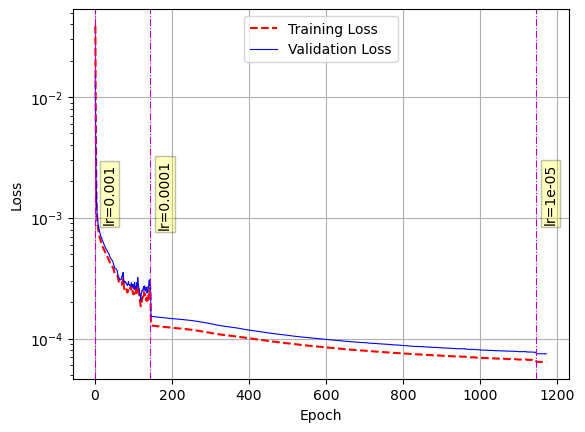

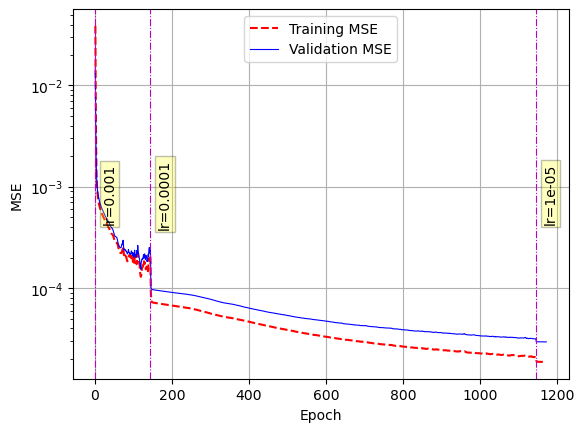

<Figure size 640x480 with 0 Axes>

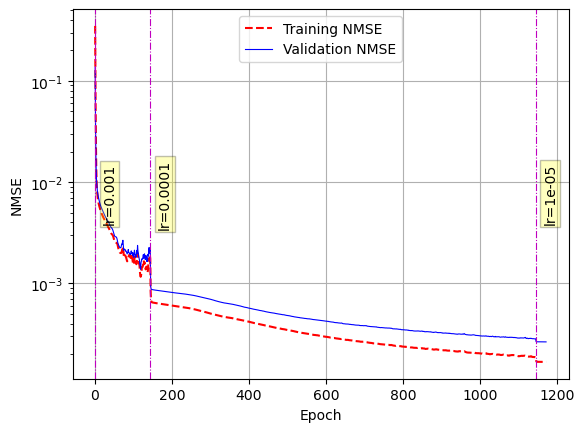

<Figure size 640x480 with 0 Axes>

In [37]:
# plotting losses
dir_name_plot = dir_name_rnn+dir_sep+'plots'
if not os.path.isdir(dir_name_plot):
    os.makedirs(dir_name_plot)

# Visualize loss history
fig, ax = plot_losses(
    training_loss=train_loss_hist,
    val_loss=val_loss_hist,
    lr_change=lr_change,
    learning_rate_list=learning_rate_list
)

plt.savefig(dir_name_rnn+'{ds}plots{ds}loss_history.png'.format(ds=dir_sep), dpi=300, bbox_inches='tight')
plt.show()


fig, ax = plot_losses(
    training_loss=train_MSE_hist,
    val_loss=val_MSE_hist,
    lr_change=lr_change,
    learning_rate_list=learning_rate_list,
    legend_list=['Training MSE', 'Validation MSE'],
    xlabel='Epoch',
    ylabel='MSE',
)
plt.savefig(dir_name_rnn+'/plots/MSE_history.png', dpi=300, bbox_inches='tight')
plt.show()
plt.clf()

fig, ax = plot_losses(
    training_loss=train_NMSE_hist,
    val_loss=val_NMSE_hist,
    lr_change=lr_change,
    learning_rate_list=learning_rate_list,
    legend_list=['Training NMSE', 'Validation NMSE'],
    xlabel='Epoch',
    ylabel='NMSE',
)
plt.savefig(dir_name_rnn+'/plots/NMSE_history.png', dpi=300, bbox_inches='tight')
plt.show()
plt.clf()

data_idx : 52


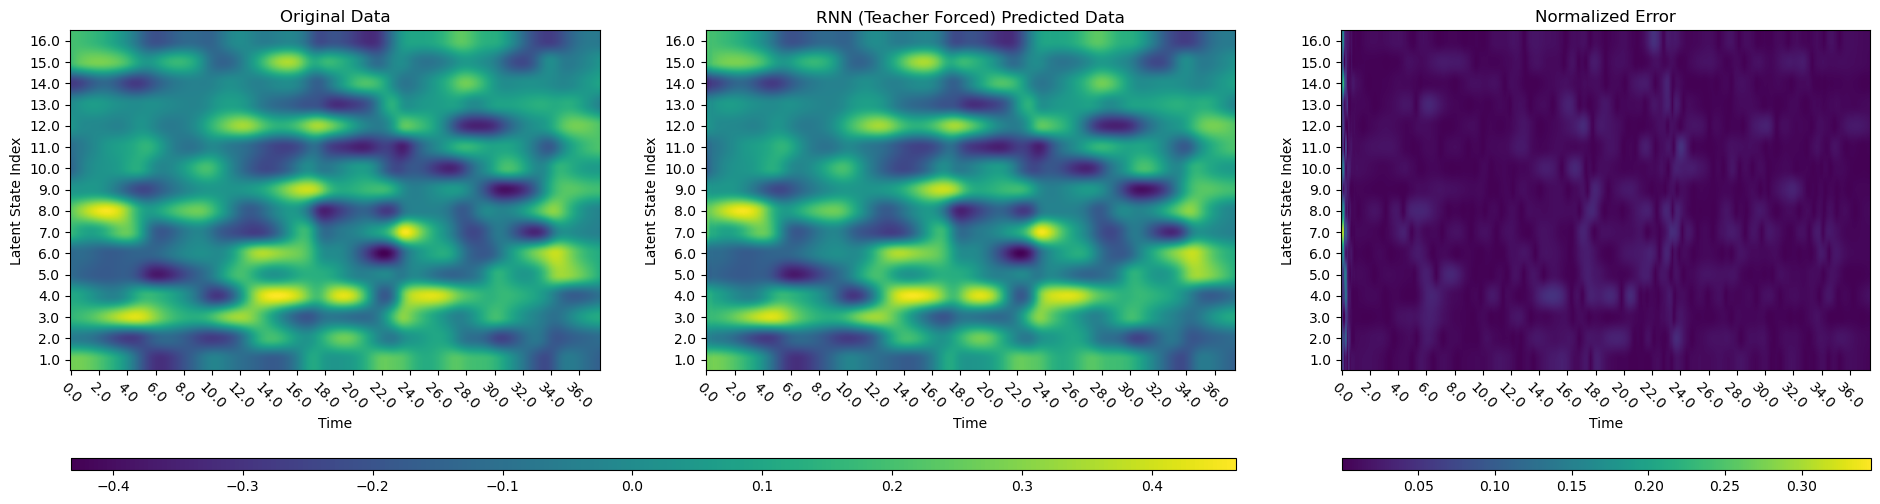

In [38]:
# data_type = 'training'
rnn_net.reset_states()
data_type = 'testing'

data_in = eval(data_type+'_data_rnn_input')
data_out = eval(data_type+'_data_rnn_output')

data_idx = np.arange(data_in.shape[0])
np.random.shuffle(data_idx)
data_idx = data_idx[0]
# data_idx = 3788
print('data_idx : {}'.format(data_idx))

# data_in = data_in[data_idx]
data_out = data_out[data_idx]

prediction = rnn_net.predict(data_in[data_idx:data_idx+1, :, :])

plot_reconstructed_data_KS(
    [data_out.shape[0]],
    dir_name_ae,
    data_out,
    prediction[0], delta_t, 1+np.arange(0, data_out.shape[1]),
    save_figs=False,
    normalization_constant_arr=normalization_arr,
    xticks_snapto=2,
    num_yticks=data_out.shape[1],
    ylabel=r'Latent State Index',
    ax1_title=r'Original Data',
    ax2_title=r'RNN (Teacher Forced) Predicted Data')

In [39]:
prediction.shape, data_out.shape

((32, 375, 16), (375, 16))

In [40]:
def rescale_data(data, normalization_arr):
    '''
    data - [num_batches x num_timesteps x num_states]
    normalization_arr = [2 x num_states]
    '''
    new_data = data.copy()
    shape = new_data.shape
    for i in range(data.shape[-1]):
        new_data[:, i] -= normalization_arr[0, i]
        new_data[:, i] /= normalization_arr[1, i]

    return new_data

def norm_sq_time_average(data):
    data_norm_sq = np.zeros(shape=data.shape[0])
    for i in range(data.shape[1]):
        data_norm_sq[:] += data[:, i]**2
    # integrating using the trapezoidal rule
    norm_sq_time_avg = np.sum(data_norm_sq) - 0.5*(data_norm_sq[0]+data_norm_sq[-1])
    norm_sq_time_avg /= data_norm_sq.shape[0]
    return norm_sq_time_avg

def invert_normalization(data, normalization_arr):
    new_data = data.copy()
    shape = new_data.shape
    for i in range(shape[-1]):
        if len(shape) == 2:
            new_data[:, i] *= normalization_arr[1, i]
            new_data[:, i] += normalization_arr[0, i]
        elif len(shape) == 3:
            new_data[:, :, i] *= normalization_arr[1, i]
            new_data[:, :, i] += normalization_arr[0, i]
    return new_data

case 1, data_idx : 26


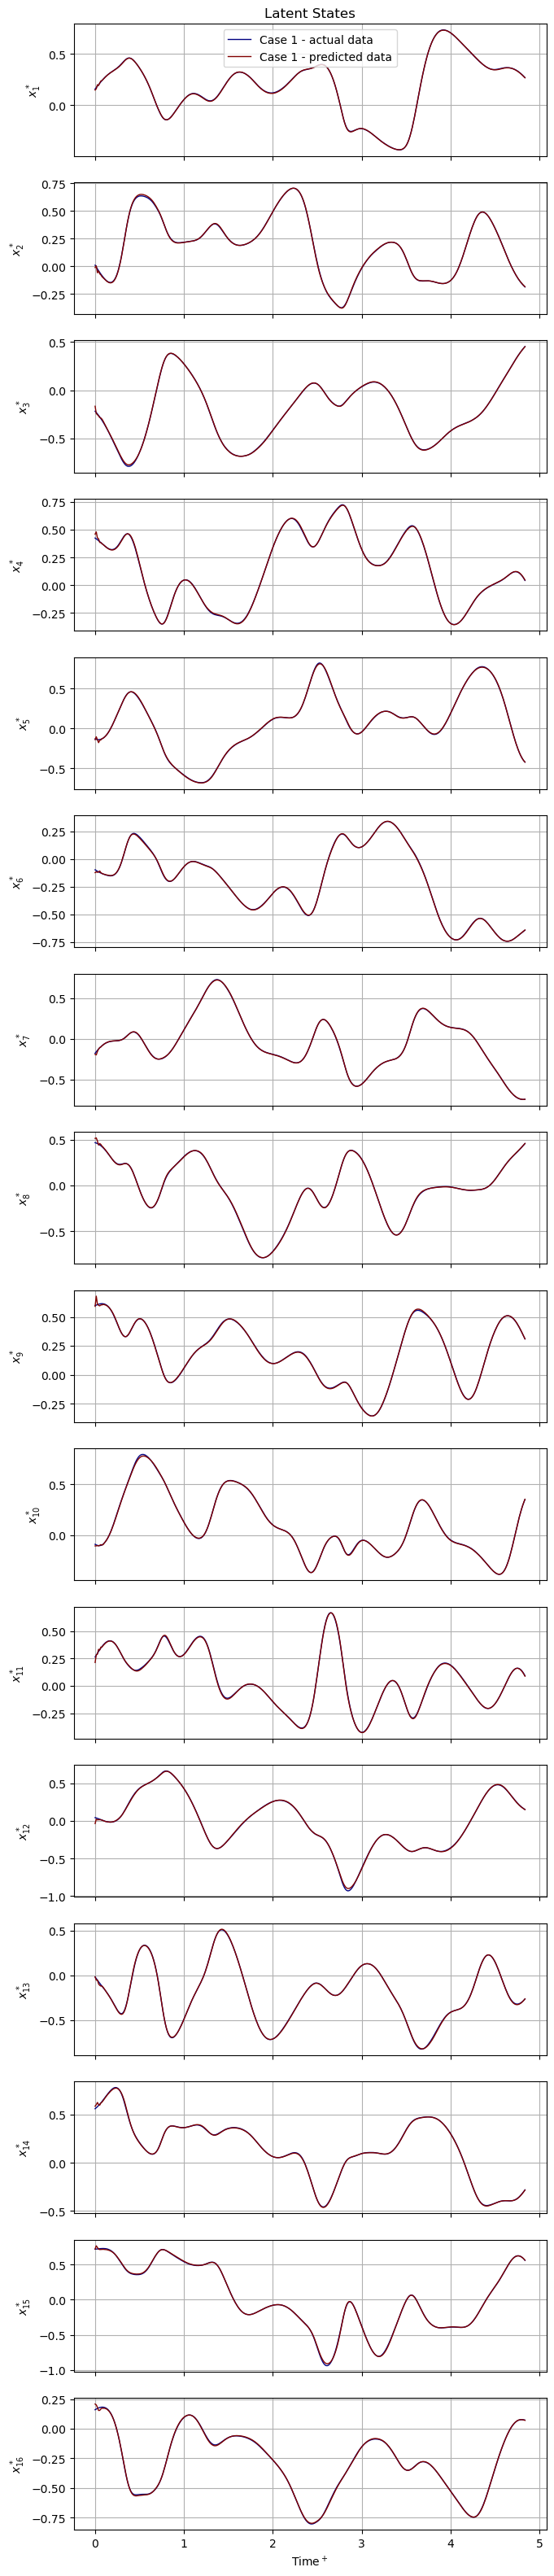


4.8363212491718865


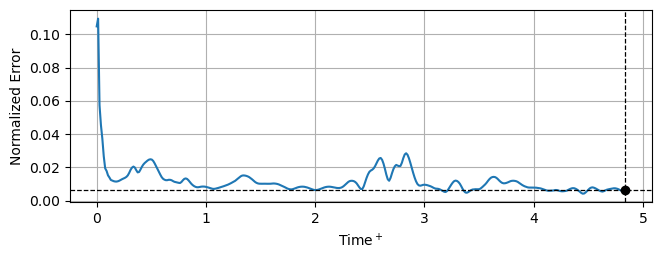

In [41]:
if rnn_net.stateful == True:
    for rnn_layer in rnn_net.rnn_list:
        rnn_layer.reset_states()


data_in = testing_data_rnn_input
data_out = testing_data_rnn_output

data_idx = np.arange(data_in.shape[0])
np.random.shuffle(data_idx)
data_idx = data_idx[0]
# data_idx = 11269
for i in range(len(rnn_data_boundary_idx_arr)):
    if data_idx < rnn_data_boundary_idx_arr[i]:
        case_idx = i
        break
lyap_time = lyapunov_time_arr[case_idx]

print('case {}, data_idx : {}'.format(case_idx+1, data_idx))

# data_in = data_in[data_idx]
data_out = data_out[data_idx]
# data_out = rescale_data(data_out, normalization_arr)
# data_out = invert_normalization(data_out, normalization_arr)

prediction = rnn_net.predict(data_in[data_idx:data_idx+1, :, :])
# prediction = rnn_net(data_in[data_idx:data_idx+1, :, :], training=False)
# prediction = rnn_net.call(data_in[data_idx:data_idx+1, :, :], training=False)
# prediction = invert_normalization(prediction, normalization_arr)

n = 1
num_latent_states = data_out.shape[-1]
N = data_out.shape[0]

num_cols = 1
num_rows = n*num_latent_states

ax_ylabels = ['$x^*_{' +str(i)+'}$' for i in range(1, num_latent_states+1)]

fig, ax = plt.subplots(num_latent_states, 1, sharex=True, figsize=(7.5*num_cols, 2.5*num_rows))
if num_latent_states == 1:
    ax = [ax]
input_time = np.arange(0, N)*dt_rnn/lyap_time

cmap = plt.get_cmap('jet')
colors = [cmap(i) for i in np.linspace(0, 1, 2*n)]

prev_idx = 0

mpl_ax_artist_list = []
for j in range(num_latent_states):
    for i in range(n):
        obj_in = ax[j].plot(input_time, data_out[:, j], linewidth=1, color=colors[2*i], label='Case {} - actual data'.format(i+1))
        obj_out = ax[j].plot(input_time, prediction[0, :, j], linewidth=1, color=colors[2*i+1], label='Case {} - predicted data'.format(i+1))
        mpl_ax_artist_list.append(obj_in[0])
        mpl_ax_artist_list.append(obj_out[0])
    ax[j].set_ylabel(ax_ylabels[j])
    # if xlim is not None:
    #     ax[j].set_xlim(xlim)
    # if ylim is not None:
    #     ax[j].set_ylim(ylim)
    ax[j].grid(True)
    ax[j].set_axisbelow(True)


ax[-1].set_xlabel('Time$^+$')

max_rows = 10
max_rows = float(max_rows)
ncols = int(np.ceil(len(boundary_idx_arr) / max_rows))
ax[0].legend(
    loc='best',
    ncol=ncols,
)
ax[0].set_title(r'Latent States', size=12)
plt.show()
# plt.savefig('AR-GRU.png', dpi=300, bbox_inches='tight')
print('')

### Error and prediction horizon
# error = np.linalg.norm(data_out[:, :] - prediction[0, :, :], axis=1)
error = (data_out[:, :] - prediction[0, :, :])**2
# error /= norm_sq_time_average(data_out)**0.5
error = np.mean(np.divide(error, time_stddev**2), axis=1)**0.5

# print(norm_sq_time_average(data_out)**0.5)

fig2, ax2 = plt.subplots(1, 1, figsize=(7.5, 2.5))
ax2.plot(input_time, error)
ax2.grid(True)
ax2.set_axisbelow(True)
ax2.set_xlabel('Time$^+$')
ax2.set_ylabel('Normalized Error')

error_threshold = 0.5

predhor_idx = np.where(error >= error_threshold)[0]
if predhor_idx.shape[0] == 0:
    predhor_idx = error.shape[0]-1
else:
    predhor_idx = predhor_idx[0]
ax2.plot(input_time[predhor_idx], error[predhor_idx], 'o', color='k')
ax2.axhline(error[predhor_idx], linewidth=0.9, linestyle='--', color='k')
ax2.axvline(input_time[predhor_idx], linewidth=0.9, linestyle='--', color='k')

prediction_horizon = predhor_idx*dt_rnn/lyap_time
print(prediction_horizon)

plt.show()

# Auto Regressive ESN

In [42]:
s_in = testing_data_rnn_input.shape
s_out = testing_data_rnn_output.shape

if stateful == True:
    temp1 = np.zeros_like(testing_data_rnn_input)
    temp2 = np.zeros_like(testing_data_rnn_output)
    testing_data_rolling_count = 0
    for i in range(len(rnn_data_boundary_idx_arr)):
        # idx = np.arange(begin_idx, rnn_data_boundary_idx_arr[i])
        num_samples = num_samples_arr[i]
        num_train = num_train_arr[i]
        num_val = num_val_arr[i]
        num_test = num_test_arr[i]

        nbatches_test = num_test // batch_size

        for j in range(batch_size):
            temp1[testing_data_rolling_count+j*nbatches_test:testing_data_rolling_count+(j+1)*nbatches_test] = testing_data_rnn_input[testing_data_rolling_count:testing_data_rolling_count+num_test:batch_size]
            temp2[testing_data_rolling_count+j*nbatches_test:testing_data_rolling_count+(j+1)*nbatches_test] = testing_data_rnn_output[testing_data_rolling_count:testing_data_rolling_count+num_test:batch_size]

        testing_data_rolling_count += num_test

    del(testing_data_rnn_input)
    testing_data_rnn_input = temp1
    del(testing_data_rnn_output)
    testing_data_rnn_output = temp2

testing_data_rnn_input = testing_data_rnn_input.reshape((1, s_in[0]*s_in[1]) + s_in[2:])
testing_data_rnn_output = testing_data_rnn_output.reshape((1, s_out[0]*s_out[1]) + s_out[2:])
# testing_data_rnn_input = testing_data_rnn_input.reshape((s_in[0], s_in[1], s_in[2]))
# testing_data_rnn_output = testing_data_rnn_output.reshape((s_out[0], s_out[1], s_out[2]))

In [43]:
T_sample_input_AR = 1*np.mean(lyapunov_time_arr)#50.1*dt_rnn
num_sample_input_AR = int((T_sample_input_AR+0.5*dt_rnn)//dt_rnn)

T_sample_output_AR = 5*np.mean(lyapunov_time_arr)
num_sample_output_AR = int((T_sample_output_AR+0.5*dt_rnn)//dt_rnn)

num_offset_AR = num_sample_input_AR
T_offset_AR = num_offset_AR*dt_rnn

batch_idx : 0
data_idx : 2454
data_.shape : (1, 464, 16)


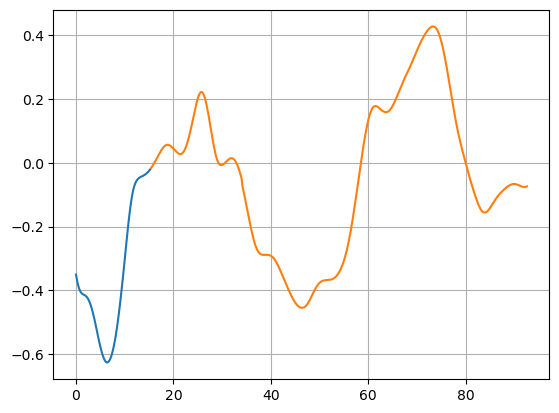

In [44]:
# data_to_consider = 'training'
data_to_consider = 'testing'

data_in = eval(data_to_consider+'_data_rnn_input')
data_out = eval(data_to_consider+'_data_rnn_output')

batch_idx = np.random.randint(low=0, high=data_in.shape[0])
maxpossible_num_runs = data_in.shape[1]-(num_sample_input_AR+num_sample_output_AR)

data_idx = np.random.randint(low=0, high=maxpossible_num_runs)

print('batch_idx : {}'.format(batch_idx))
print('data_idx : {}'.format(data_idx))
data_ = data_in[batch_idx:batch_idx+1, data_idx:data_idx+(num_sample_input_AR+num_sample_output_AR), :]
print('data_.shape :', data_.shape)

plt.plot(dt_rnn*np.arange(num_sample_input_AR), data_[0, 0:num_sample_input_AR, 0])
plt.plot(dt_rnn*num_sample_input_AR+dt_rnn*np.arange(num_sample_output_AR), data_[0, num_sample_input_AR:, 0])
plt.grid(True)
plt.show()

In [45]:
prediction_lst = []

for layer in rnn_net.rnn_list:
    layer.reset_states()

ar_rnn_input = np.tile(data_[:, 0:num_sample_input_AR, :], [batch_size, 1, 1])
input_preds = np.array(rnn_net(ar_rnn_input, training=False))

prediction_lst.append(input_preds[:, -1:, :])

for i in range(1, num_sample_output_AR):
    data_in_i = np.array(prediction_lst[-1])
    output = np.array(rnn_net(data_in_i, training=False))[:, -1:, :]
    prediction_lst.append(output)

In [46]:
prediction_lst = np.stack(prediction_lst)


print('input_preds.shape : {}'.format(input_preds.shape))
print('prediction_lst.shape : {}'.format(prediction_lst.shape))

input_preds.shape : (32, 77, 16)
prediction_lst.shape : (387, 32, 1, 16)


In [47]:
prediction_lst = np.transpose(prediction_lst, [1, 0, 2, 3])

In [48]:
print('prediction_lst.shape : {}'.format(prediction_lst.shape))

prediction_lst.shape : (32, 387, 1, 16)


In [50]:
prediction_lst = np.squeeze(prediction_lst)

In [51]:
print('prediction_lst.shape : {}'.format(prediction_lst.shape))

prediction_lst.shape : (32, 387, 16)


0.8276057752593604


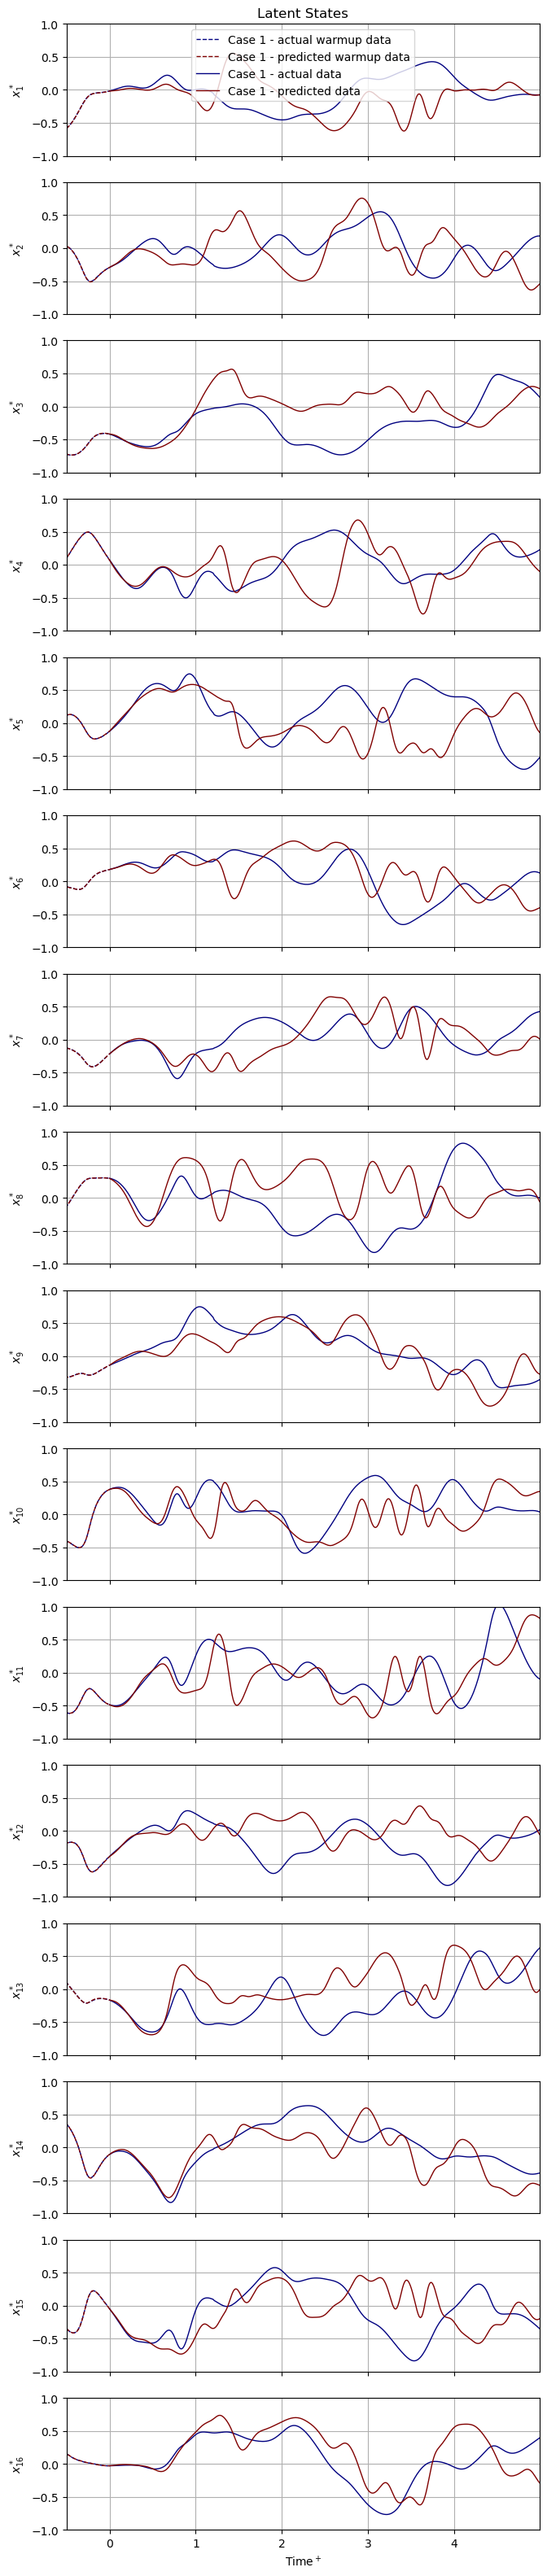

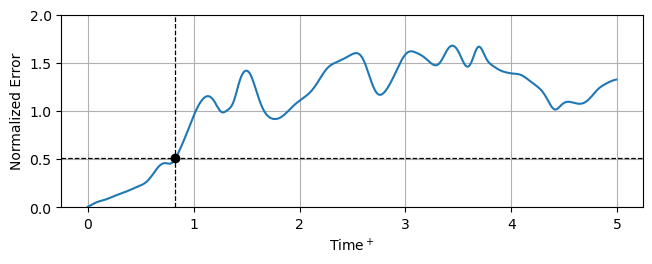

In [52]:
lyap_time = np.mean(lyapunov_time_arr)

n = 1
num_latent_states = input_preds.shape[-1]
N = num_sample_output_AR#num_output_timesteps

num_cols = 1
num_rows = n*num_latent_states

ax_ylabels = [r'$x^*_{'+str(i+1)+'}$' for i in range(num_latent_states)]

fig, ax = plt.subplots(num_latent_states, 1, sharex=True, figsize=(7.5*num_cols, 2.5*num_rows))
if num_latent_states == 1:
    ax = [ax]

cmap = plt.get_cmap('jet')
colors = [cmap(i) for i in np.linspace(0, 1, 2*n)]

prev_idx = 0

time_arr_warmup1 = (np.arange(num_sample_input_AR) - num_sample_input_AR)*dt_rnn
time_arr_warmup2 = time_arr_warmup1 + dt_rnn

time_arr_warmup1 /= lyap_time
time_arr_warmup2 /= lyap_time

input_time = time_arr_warmup2[-1]+np.arange(N, dtype=float)*dt_rnn/lyap_time

for j in range(num_latent_states):
    for i in range(n):
        ax[j].plot(time_arr_warmup1, data_[0, 0:num_sample_input_AR, j], linestyle='--', linewidth=1, color=colors[2*i], label='Case {} - actual warmup data'.format(i+1))
        ax[j].plot(time_arr_warmup2, input_preds[0, :, j], linestyle='--', linewidth=1, color=colors[2*i+1], label='Case {} - predicted warmup data'.format(i+1))
        ax[j].plot(input_time, data_[0, num_sample_input_AR:num_sample_input_AR+N, j], linewidth=1, color=colors[2*i], label='Case {} - actual data'.format(i+1))
        ax[j].plot(input_time, prediction_lst[0, :, j], linewidth=1, color=colors[2*i+1], label='Case {} - predicted data'.format(i+1))
    ax[j].set_ylabel(ax_ylabels[j])
    ax[j].grid(True)
    ax[j].set_axisbelow(True)
    ax[j].set_ylim([-1, 1])
    ax[j].set_xlim([input_time[0] - 0.5, input_time[-1]])


ax[-1].set_xlabel('Time$^+$')

max_rows = 10
max_rows = float(max_rows)
ncols = int(np.ceil(len(boundary_idx_arr) / max_rows))
ax[0].legend(
    loc='best',
    ncol=ncols,
)
ax[0].set_title(r'Latent States', size=12)


### error computation
error = (data_[0, num_sample_input_AR:num_sample_input_AR+N, :] - prediction_lst[0, :, :])**2
# error /= norm_sq_time_average(data_out)**0.5
error = np.mean(np.divide(error, time_stddev**2), axis=1)**0.5

# print(norm_sq_time_average(data_out)**0.5)

fig2, ax2 = plt.subplots(1, 1, figsize=(7.5, 2.5))
ax2.plot(input_time, error)
ax2.grid(True)
ax2.set_axisbelow(True)
ax2.set_xlabel('Time$^+$')
ax2.set_ylabel('Normalized Error')

error_threshold = 0.5

predhor_idx = np.where(error >= error_threshold)[0]
if len(predhor_idx.shape) == 0:
    predhor_idx = error.shape[0]-1
else:
    predhor_idx = predhor_idx[0]
ax2.plot(input_time[predhor_idx], error[predhor_idx], 'o', color='k')
ax2.axhline(error[predhor_idx], linewidth=0.9, linestyle='--', color='k')
ax2.axvline(input_time[predhor_idx], linewidth=0.9, linestyle='--', color='k')
ax2.set_ylim([0, 2])

prediction_horizon = predhor_idx*dt_rnn/lyap_time
print(prediction_horizon)

In [53]:
if use_weights_post_dense == True:
    print(rnn_net.postWout.individual_weights)

<tf.Variable 'single_weights/individual_weights:0' shape=(16,) dtype=float32, numpy=
array([1.276127 , 1.3856162, 1.3479139, 1.2711997, 1.2752444, 1.3438448,
       1.3283468, 1.3806584, 1.285216 , 1.286255 , 1.374914 , 1.2953486,
       1.3905236, 1.3885202, 1.3518829, 1.3436562], dtype=float32)>


In [54]:
def plot_histogram_and_save(
    prediction_horizon_arr,
    save_dir,
    savefig_fname='pre_ARtraining',
    bin_width=0.05,
    bin_begin=0.0):
    
    fig, ax = plt.subplots()

    ph_mean = np.mean(prediction_horizon_arr)
    ph_stddev = np.std(prediction_horizon_arr)
    ph_max = np.max(prediction_horizon_arr)
    ph_min = np.min(prediction_horizon_arr)
    
    bin_end = bin_width*np.round((np.max(prediction_horizon_arr)+0.5*bin_width)//bin_width)
    nbins = int(np.round(bin_end/bin_width))

    ax.hist(prediction_horizon_arr, bins=nbins, range = [bin_begin, bin_end], density=True)
    ax.axvline(ph_mean, linewidth=0.9, linestyle='--', color='k')

    ax.set_xlabel('Prediction Horizon (Lyapunov times)')
    ax.set_ylabel('PDF')

    ax.grid(True)
    # ax.set_axisbelow(True)

    ax.text(
        0.01 + ax.transAxes.inverted().transform(ax.transData.transform([prediction_horizon, 0]))[0],
        0.8,
        'mean',
        rotation=90,
        verticalalignment='bottom',
        horizontalalignment='left',
        bbox=dict(facecolor=np.array([255,255,153])/255, alpha=1, boxstyle='square,pad=0.2'),
        transform=ax.transAxes
    )

    text_xy = [0.95, 0.95]
    ax.text(
        text_xy[0],
        text_xy[1],
        'mean : {:.4f}\nmax : {:.4f}\nmin : {:.4f}\nstddev : {:.4f}'.format(
            ph_mean,
            ph_max,
            ph_min,
            ph_stddev,
        ),
        transform=ax.transAxes,
        bbox=dict(
            boxstyle="round",
            ec=(0.6, 0.6, 1),
            fc=(0.9, 0.9, 1),
        ),
        # bbox=dict(facecolor='C0', alpha=0.5, boxstyle='round,pad=0.2'),
        horizontalalignment='right',
        verticalalignment='top'
    )

    ax.set_title('nbins = {}'.format(nbins))
    
    if not os.path.isdir(save_dir):
        os.mkdir(save_dir)

    fig.savefig(save_dir+'/'+savefig_fname+'.png', dpi=300, bbox_inches='tight')
    fig.clear()
    plt.close()

In [55]:
num_runs = 100
num_runs = np.min([num_runs, maxpossible_num_runs])
print(num_runs)

data_idx_arr = np.linspace(0, maxpossible_num_runs-1, num_runs, dtype=np.int32)

savefig_fname = 'pre_ARtraining-'+data_to_consider+'data'
npsavedata_fname = '/prediction_horizons-'+data_to_consider+'data'
plot_dir = '/plots'

analysis_time = time.time()

sidx1 = dir_name_rnn[::-1].index('/')
sidx2 = dir_name_rnn[-sidx1-2::-1].index('/')
print(dir_name_rnn[-(sidx1+sidx2+1):])

prediction_horizon_arr = np.empty(shape=num_runs)

for i in range(num_runs):
    data_idx = data_idx_arr[i]

    # for j in range(len(rnn_data_boundary_idx_arr)):
    #     if data_idx < rnn_data_boundary_idx_arr[j]:
    #         case_idx = j
    #         break
    lyap_time = lyapunov_time_arr[0]

    ### picking the data
    data_ = data_in[0:1, data_idx:data_idx+(num_sample_input_AR+num_sample_output_AR), :]

    ### doing the predictions
    prediction_lst = []

    for layer in rnn_net.rnn_list:
        layer.reset_states()

    ar_rnn_input = np.tile(data_[:, 0:num_sample_input_AR, :], [batch_size, 1, 1])
    input_preds = np.array(rnn_net(ar_rnn_input, training=False))

    prediction_lst.append(input_preds[:, -1:, :])

    for j in range(1, num_sample_output_AR):
        data_in_j = np.array(prediction_lst[-1])
        output = np.array(rnn_net(data_in_j, training=False))[:, -1:, :]
        prediction_lst.append(output)
        
    prediction_lst = np.stack(prediction_lst)
    prediction_lst = np.squeeze(prediction_lst)
    prediction_lst = np.transpose(prediction_lst, [1, 0, 2])[0]
    # prediction_lst = invert_normalization(prediction_lst, normalization_arr)
    
    input_preds = input_preds[0, :, :]
    
    data_out = data_[0, num_sample_input_AR:num_sample_input_AR+num_sample_output_AR, :]
    # data_out = invert_normalization(data_out, normalization_arr)

    ### Error and prediction horizon
    # error = np.linalg.norm(data_out[:, :] - prediction[i, :, :], axis=1)
    error = (data_out[:, :] - prediction_lst[:, :])**2
    # error /= norm_sq_time_average(data_out)**0.5
    error = np.mean(np.divide(error, time_stddev**2), axis=1)**0.5 # use time_stddev_AEproducedlatentstates if using invert_normaliztion

    predhor_idx = np.where(error >= error_threshold)[0]
    if predhor_idx.shape[0] == 0:
        predhor_idx = error.shape[0]
    else:
        predhor_idx = predhor_idx[0]

    prediction_horizon_arr[i] = predhor_idx*dt_rnn/lyap_time

median_idx = int(np.round(0.5*num_runs-1))
quartile_1_idx = int(np.round(0.25*num_runs-1))
quartile_3_idx = int(np.round(0.75*num_runs-1))

prediction_horizon_arr.sort()

median = prediction_horizon_arr[median_idx]
quartile_1 = prediction_horizon_arr[quartile_1_idx]
quartile_3 = prediction_horizon_arr[quartile_3_idx]
IQR = quartile_3 - quartile_1

prediction_horizon = np.mean(prediction_horizon_arr)
stddev_ph = np.std(prediction_horizon_arr)

s = 'num_runs : {}, error_threshold = {}\n'.format(num_runs, error_threshold)
s += 'prediction_horizon : {}, median : {}\n'.format(prediction_horizon, median)
s += 'ph_min : {}, ph_max : {}\n'.format(prediction_horizon_arr.min(), prediction_horizon_arr.max())
s += 'stddev : {}, IQR : {}\n'.format(stddev_ph, IQR)
s += '1st quartile : {}, 3rd quartile : {}'.format(quartile_1, quartile_3)

print('\n'+s)

plot_histogram_and_save(
    prediction_horizon_arr,
    save_dir=dir_name_rnn+plot_dir,
    savefig_fname=savefig_fname
)

npsavedata_fname = '/prediction_horizons-'+data_to_consider+'data'
np.savez(
    dir_name_rnn+npsavedata_fname,
    prediction_horizon_arr=prediction_horizon_arr,
    error_threshold=error_threshold,
)

with open(dir_name_rnn+npsavedata_fname+'--statistics.txt', 'w') as fl:
    fl.write(s)

print('analysis time : {} s\n'.format(time.time() - analysis_time))

100
saved_ESN/ESN_030

num_runs : 100, error_threshold = 0.5
prediction_horizon : 0.6596276655621871, median : 0.5560476302523827
ph_min : 0.0, ph_max : 1.8621129943335608
stddev : 0.33626704000007884, IQR : 0.28448948524540507
1st quartile : 0.43966556810653523, 3rd quartile : 0.7241550533519403
analysis time : 132.1573028564453 s

